In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../src/scenes/')
import syndiff as sd 
from ps1_data_handler import ps1_data
from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize
from astropy.stats import sigma_clipped_stats
from glob import glob
from correct_saturation import saturated_stars, _get_bsc, SkyCoord, image2counts, query_ps1
from astropy.io import fits
from astropy.wcs import WCS
import tessreduce as tr
from PRF import TESS_PRF

from photutils.aperture import CircularAperture, CircularAnnulus,RectangularAperture
from photutils.aperture import ApertureStats, aperture_photometry

from correct_saturation import ps_psf, psf_minimizer, minimize,PS1_to_TESS_mag
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
import time
import pandas as pd

In [2]:
tess_filename = '../data/tess2019360165923-s0020-1-1-0165-s_ffic.fits'
tess_hdu = fits.open(tess_filename)
tess_wcs = WCS(tess_hdu[1].header)
tess_data = tess_hdu[1].data

t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]
ty = ty.ravel().astype(int)
tx = tx.ravel().astype(int)

#ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
ps1_files = glob('../ps1_to_convolved/test/*.conv.fits')

#ps1_assignment = np.load('test_assignment.npy').astype(int)

In [5]:
ra,dec = tess_wcs.all_pix2world(tess_data.shape[1]/2,tess_data.shape[1]/2,0)
print(ra,dec)
size = 2000
y, x = np.mgrid[:size, :size]
x = x - size/2; y = y - size/2
psfg = models.Gaussian2D(x_stddev=70,y_stddev=70)
psfg = psfg(x,y)
psfg /= np.nansum(psfg)

120.110378130205 44.954336133035945


In [83]:
hdu = fits.open(ps1_files[0])
header = hdu[0].header
ps1_wcs = WCS(header)
data = image2counts(hdu[0].data,header)

In [93]:
ps1_files[0]

'../data/ps1_skycell/rings.v3.skycell.2246.012.stk.i.unconv.satcor.fits'

<IPython.core.display.Javascript object>


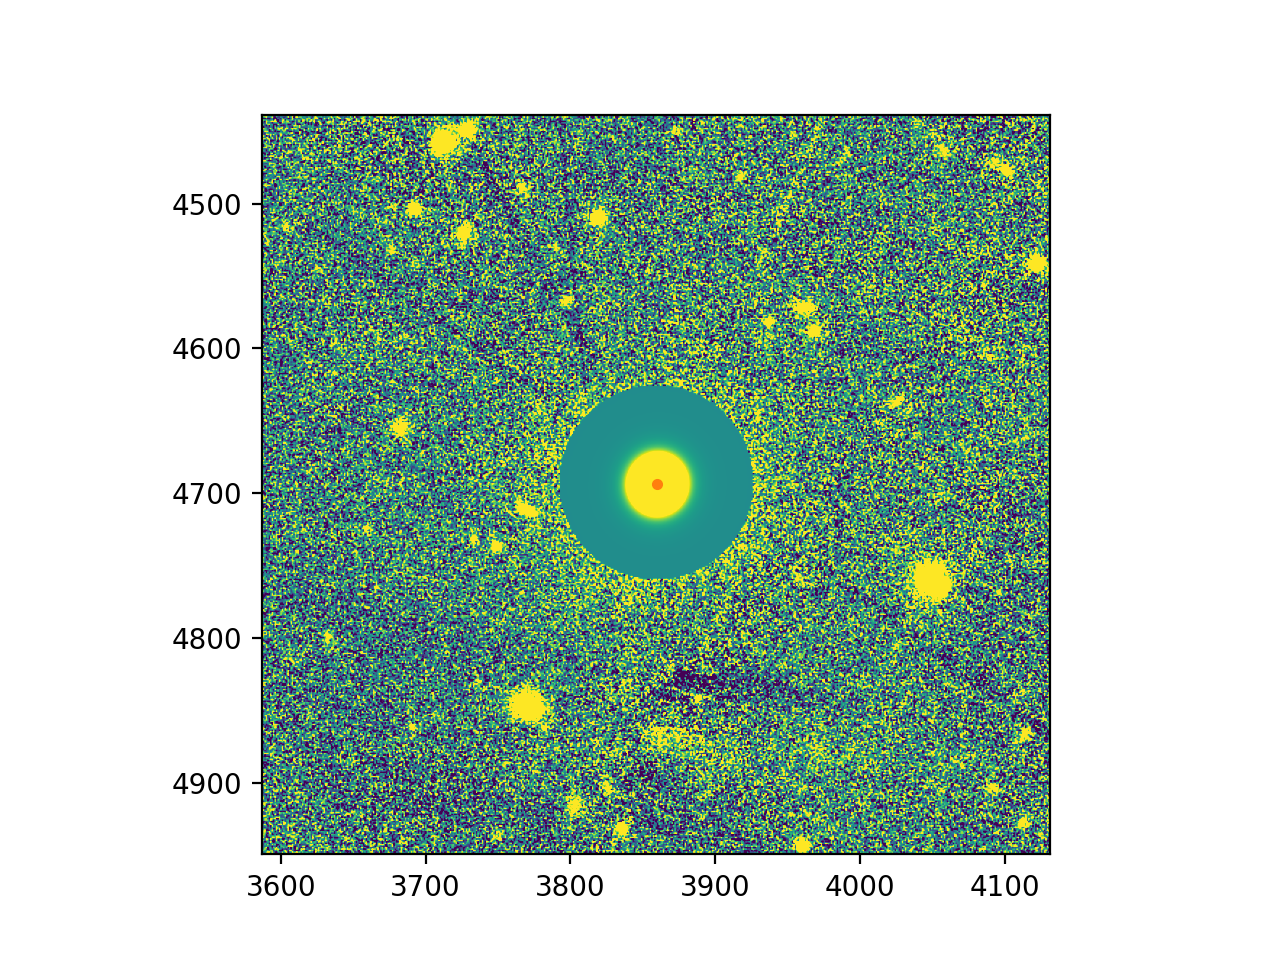

In [92]:
r_, d_ = ps1_wcs.all_pix2world(3861,4693,0)
x_,y_ = ps1_wcs.all_world2pix(r_,d_,0)

x,y = ps1_wcs.all_world2pix(119.47822169330,44.68784745750,0)
vmin = np.percentile(data,16)
vmax = np.percentile(data,84)
plt.figure()
plt.imshow(data,vmin=vmin,vmax=vmax)
plt.plot(x,y,'C1.')
#plt.plot(x_,y_,'C1*')

In [90]:
r_,d_

(array(119.47811503), array(44.68779165))

In [86]:
ps1_wcs.all_pix2world(3861,4693,0)

[array(119.47811503), array(44.68779165)]

In [79]:
ps1 = {}
cor = []
for file in ps1_files:
    hdu = fits.open(file)
    header = hdu[0].header

    data = image2counts(hdu[0].data,header)
    m,med,std = sigma_clipped_stats(data)
    ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    cor += [header['FLUXFACT']]
cor = np.array(cor)
ps1_wcs = WCS(header)

noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')


KeyError: 'r'

In [ ]:
breaks[i]:breaks[i+1]]

In [ ]:
plt.figure()
plt.hist()

In [24]:
pind = ps1_assignment.ravel()
tess_pixels = np.unique(pind)[1:]
start = time.time()
pind = ps1_assignment.ravel()
sort_ind = np.argsort(pind)
ps1_tess_rav = ps1_tess.ravel()[sort_ind]
breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
breaks = np.insert(breaks,-1,len(ps1_tess_rav))


sums = []
for i in range(len(breaks)-1):
    # first entry is 0, which is not assigned, so we can skip it
    sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]
    
scene = np.zeros_like(tess_data)
scene[ty[tess_pixels],tx[tess_pixels]] = sums
print('Time: %s' % (time.time()-start))

Time: 0.7441327571868896


<IPython.core.display.Javascript object>


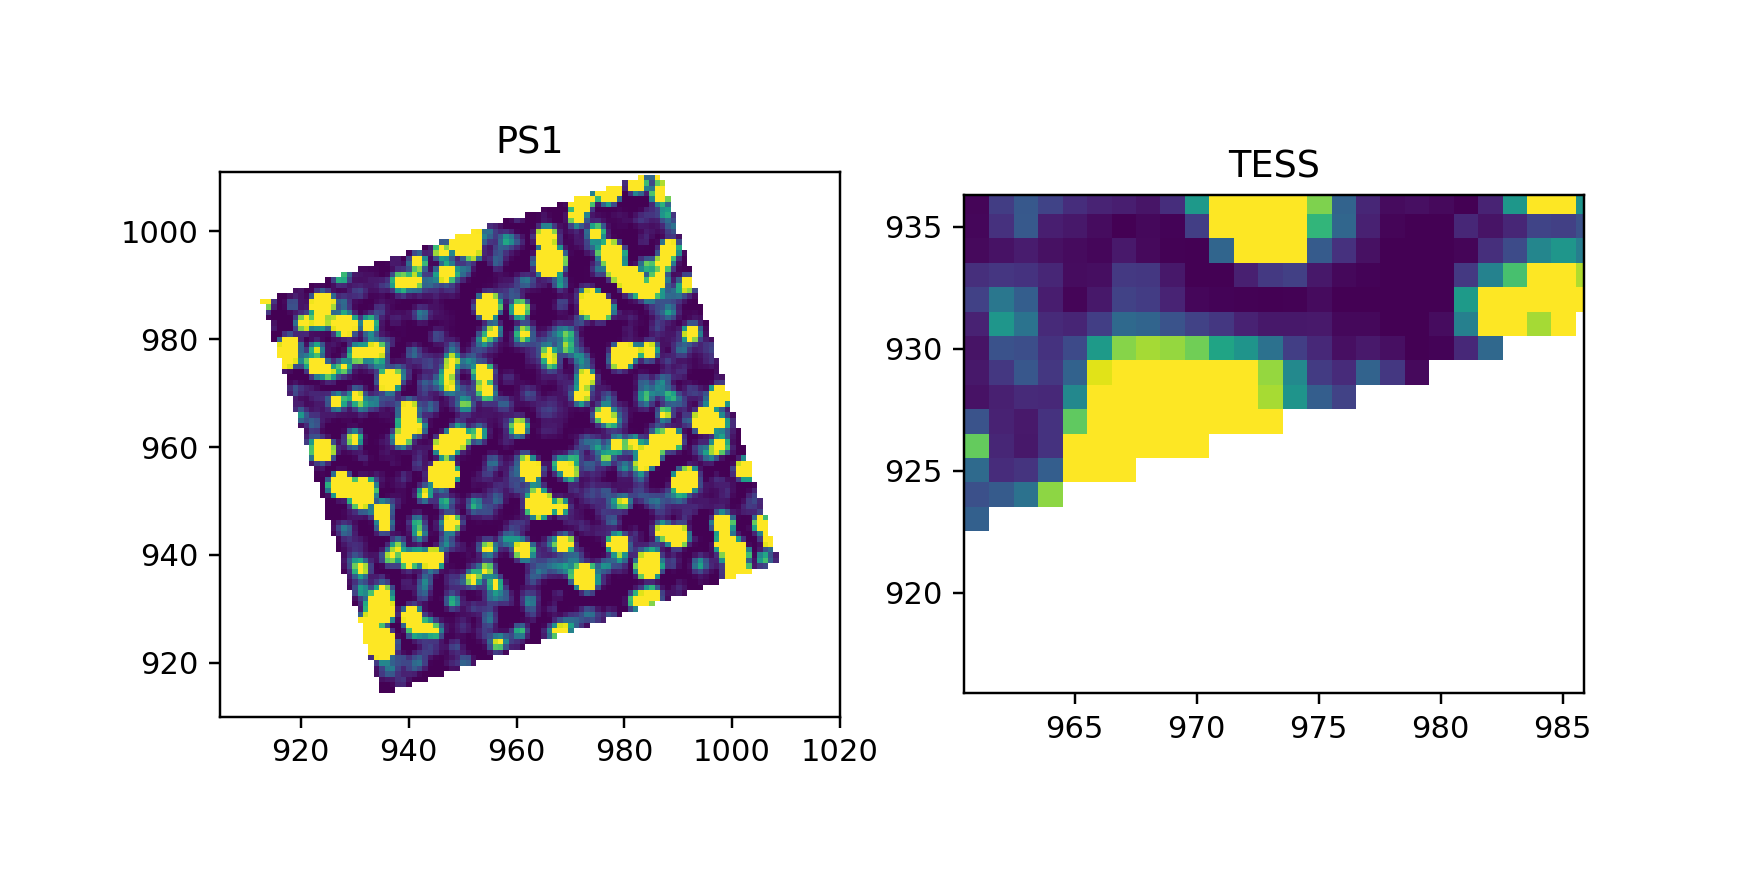

(910.0, 1011.0)

In [26]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

xmin = np.where(np.isfinite(s))[0][0] - 10
xmax = np.where(np.isfinite(s))[0][-1] + 10
ymin = np.where(np.isfinite(s))[1][0] - 10
ymax = np.where(np.isfinite(s))[1][-1] + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [ ]:
cat = query_ps1(ra,dec,0.4)
px,py = ps1_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['ps1x'] = px; cat['ps1y'] = py
_tx,_ty = tess_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = _tx; cat['tessy'] = _ty
cat = PS1_to_TESS_mag(cat)

In [29]:
sub = cat.loc[(cat.iMeanPSFMag < 17) ]# & (cat.rMeanPSFMag > 12)
#sub = cat.loc[(cat.tmag < 14) & np.isfinite(cat.tmag)  & (cat.rMeanPSFMag > 14)]
ind = ((sub.ps1x.values>100) & (sub.ps1x.values<ps1_tess.shape[1]-100) & 
       (sub.ps1y.values>100) & (sub.ps1y.values<ps1_tess.shape[0]-100) & 
       (sub.tessy.values>2) & (sub.tessy.values<tess_data.shape[0]-2) &
       (sub.tessx.values>2) & (sub.tessx.values<tess_data.shape[1]-2))

sub = sub.loc[ind]

subsub = sub.iMeanPSFMag.values >14

In [40]:
scale = 21/0.25
ap_size = 2
pos = list(zip(sub.tessx, sub.tessy))
taperture = CircularAperture(pos, ap_size)
a = tess_data
m,med,std = sigma_clipped_stats(a)
tphot_table = aperture_photometry(a-med, taperture)
#tphot_table = aperture_photometry(tess.ref, taperture)

pos = list(zip(sub.ps1x, sub.ps1y))
paperture = CircularAperture(pos, ap_size*scale)
pphot_table = aperture_photometry(ps1_tess, paperture)
aperture = CircularAperture(pos, 20)
ncpphot_table = aperture_photometry(noconvps1_tess, aperture)

ptmag = -2.5*np.log10(pphot_table['aperture_sum'].value)
ncptmag = -2.5*np.log10(ncpphot_table['aperture_sum'].value)
tmag = -2.5*np.log10(tphot_table['aperture_sum'].value)
ind = np.isfinite(tmag) & np.isfinite(ptmag)

ptmag = ptmag[ind]
tmag = tmag[ind] + 20.44
ncptmag = ncptmag[ind]

In [41]:
subsub = (tmag >13.5) & (tmag < 15)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1,fixed={'slope': True})
line_flexi = models.Linear1D(slope=1)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tmag[subsub], ptmag[subsub])
flexi_line, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
filtered_data = np.ma.masked_array(ptmag[subsub], mask=mask)

In [43]:
tmag[subsub]

array([14.69173972, 14.9207159 , 14.81649483, 14.75909215, 14.40055381,
       14.78741563, 14.72722759, 13.54492682, 14.37303517, 13.70358999,
       14.91995179, 13.68621784, 14.32044128, 14.7195278 , 14.32742347,
       14.77417311, 14.82923563, 13.9525673 , 14.81926433, 13.90715213,
       14.36157111, 14.31051926, 14.55130371, 14.81891085, 13.8194249 ,
       13.99823693, 14.39935893, 14.68141828, 14.52103098, 13.86178775,
       13.55195453, 14.59627673, 13.58652841, 13.78485869, 14.19762324,
       14.8384996 , 13.58658542, 14.6367883 , 14.68895844, 14.78077916,
       14.86687328, 13.52991289, 14.71037149, 14.41417617, 14.47724906,
       14.6621924 , 13.61093688, 13.60367984, 13.95818068, 14.53470318])

<IPython.core.display.Javascript object>


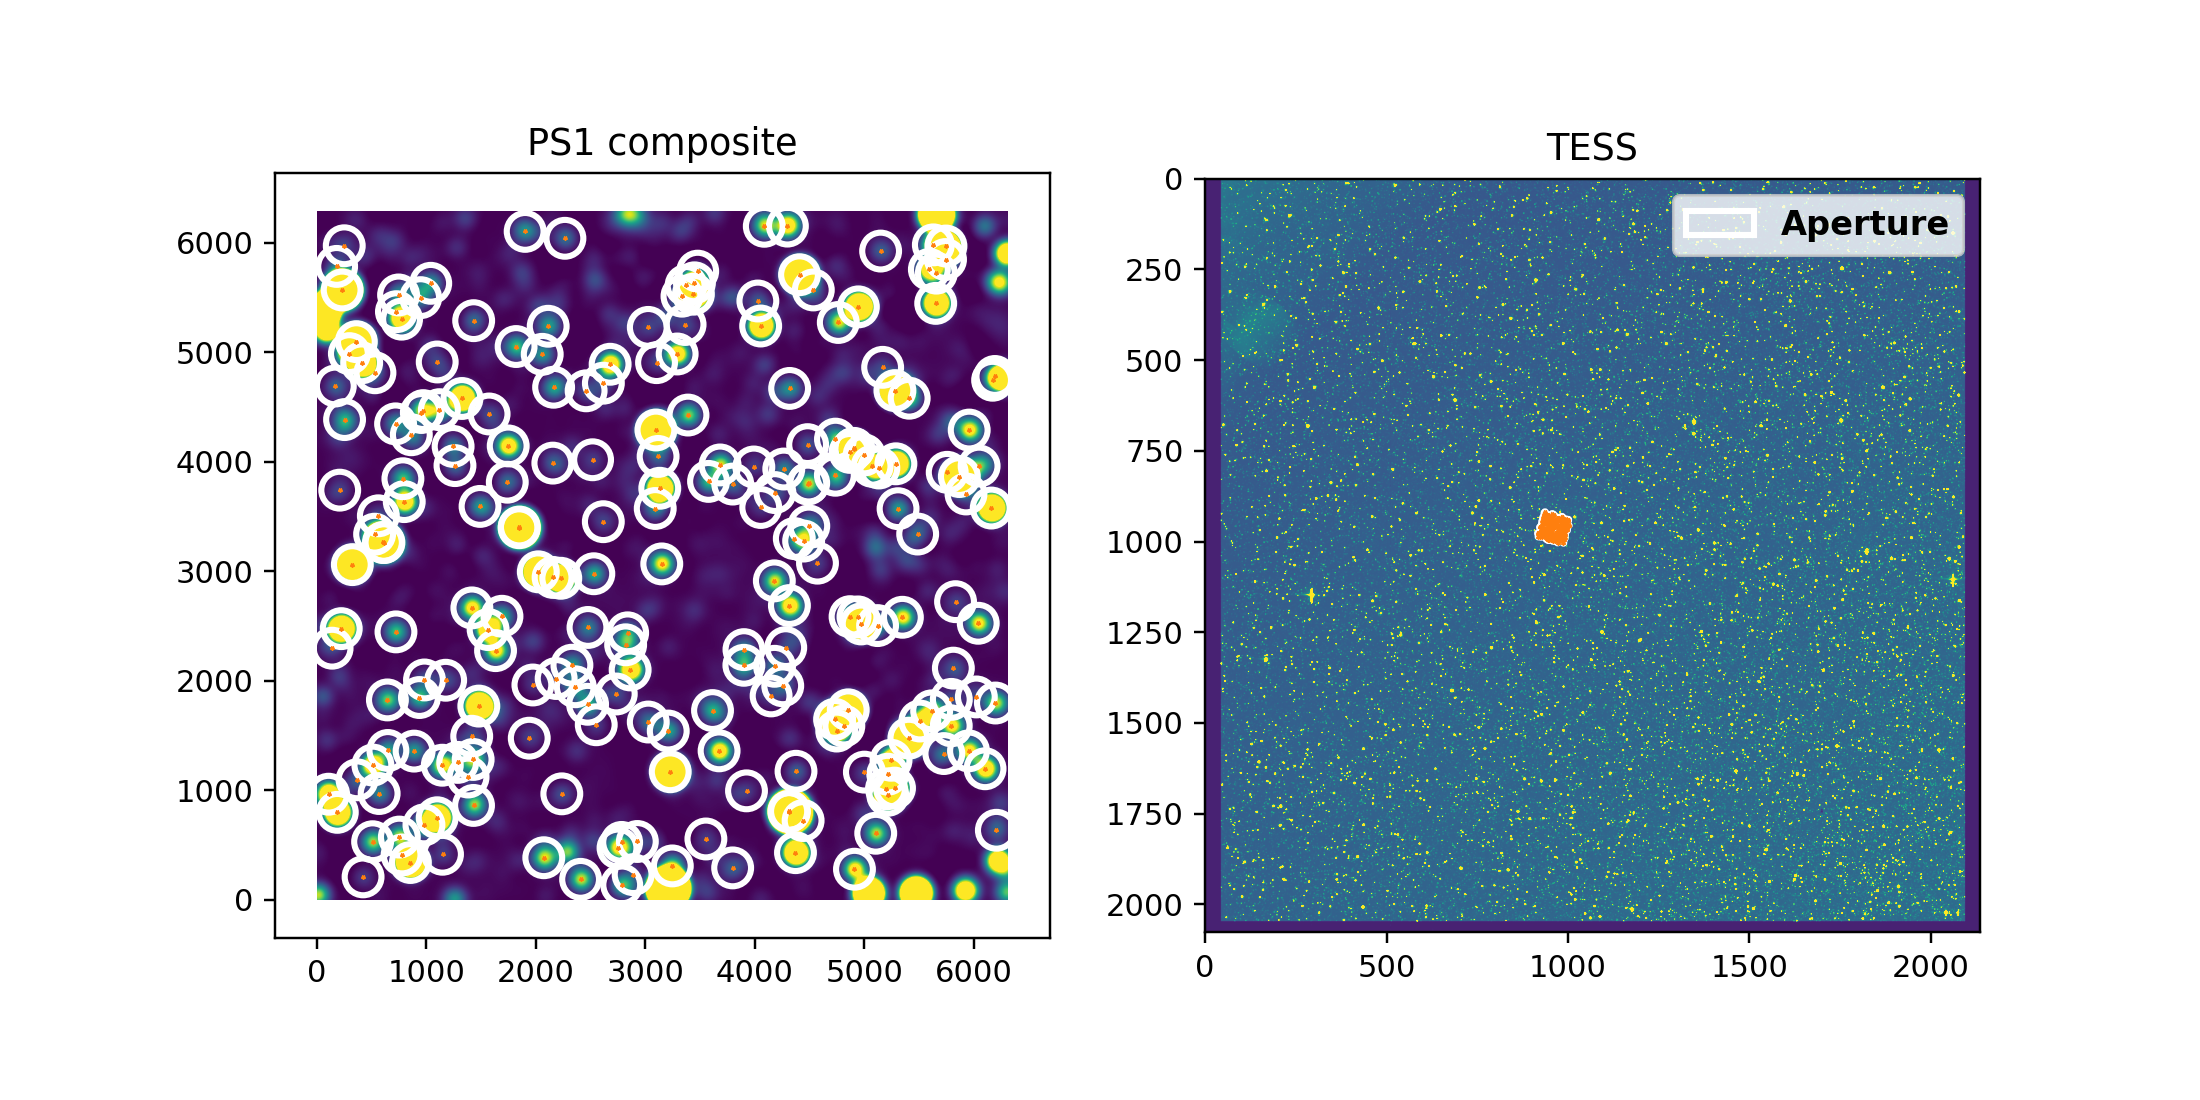

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('PS1 composite')
plt.imshow(ps1_tess,vmin=0,vmax=5e2,origin='lower')
plt.plot(sub.ps1x,sub.ps1y,'C1*',ms=1)
ap_patches = paperture.plot(color='white', lw=2,
                           label='Photometry aperture')


plt.subplot(122)
plt.subplot(122)

plt.title('TESS')
plt.imshow(tess_data,vmax=5e2)
plt.plot(sub.tessx,sub.tessy,'C1*',ms=1)
ap_patches = taperture.plot(color='white', lw=2,
                           label='Aperture')

handles = ([ap_patches[0]])
plt.legend(loc=1,
           handles=handles, prop={'weight': 'bold', 'size': 11})

<IPython.core.display.Javascript object>


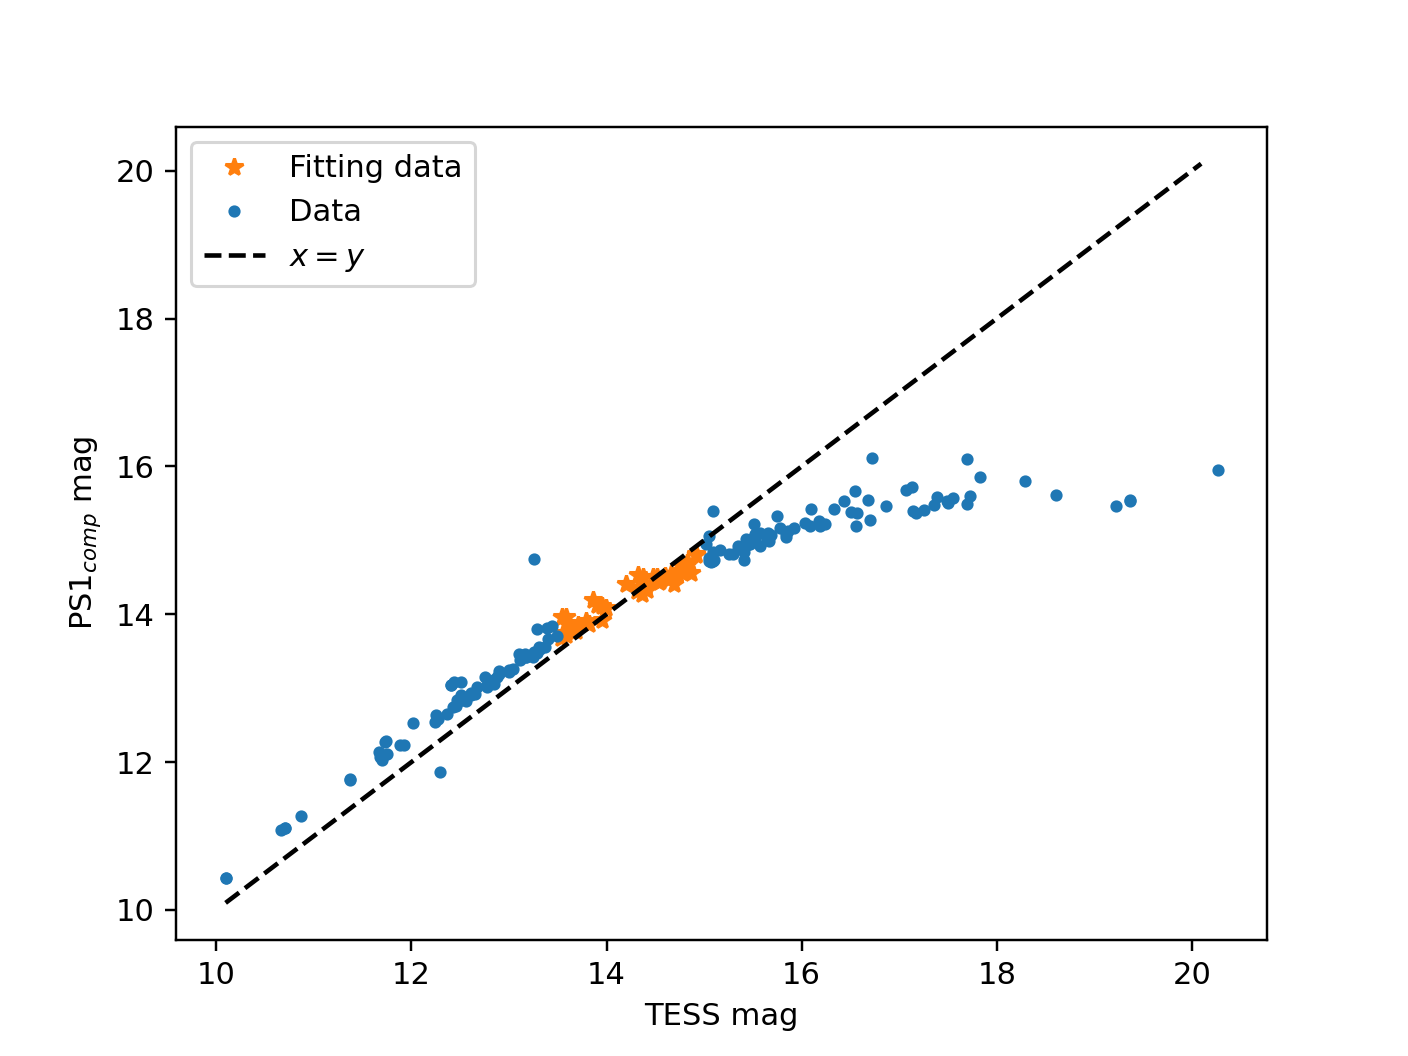

In [44]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


In [140]:
ps1_files[0]

'../ps1_to_convolved/test/rings.v3.skycell.2180.097.stk.rizy.conv.fits'

In [3]:
ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
registrations = glob('../PS1_to_TESS/bulk_test_buffer/*.npy')
skycell_path = '../data/ps1_skycell/'


scenes = []
for reg in registrations:
    ps1_assignment = np.load(reg).astype(int)
    skycell = reg.split('/')[-1].split('npy')[0]
    ps1_files = glob(skycell_path + skycell + '*.unconv.satcor.fits' )
    ps1 = {}
    for file in ps1_files:
        hdu = fits.open(file)
        header = hdu[0].header

        data = image2counts(hdu[0].data,header)
        m,med,std = sigma_clipped_stats(data)
        ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    #ps1_wcs = WCS(header)

    noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
    ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')
    # assign values 
    pind = ps1_assignment.ravel()
    tess_pixels = np.unique(pind)[1:]
    start = time.time()
    pind = ps1_assignment.ravel()
    sort_ind = np.argsort(pind)
    ps1_tess_rav = ps1_tess.ravel()[sort_ind]
    breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
    breaks = np.insert(breaks,-1,len(ps1_tess_rav))

    sums = []
    msums = []
    for i in range(len(breaks)-1):
        # first entry is 0, which is not assigned, so we can skip it
        sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]
        msums += [np.bitwise_or.reduce(mask,axis=0)]

    s = np.zeros_like(tess_data)
    s[ty[tess_pixels],tx[tess_pixels]] = sums
    print('Time: %s' % (time.time()-start))
    scenes += [s]
scenes = np.array(scenes)
scenes[scenes == 0] = np.nan
scene = np.nanmedian(scenes,axis=0)
    


KeyError: 'r'

## New

In [43]:
skycell_path = '../ps1_to_convolved/thing/'

mask_files = glob(skycell_path + '*stk.rizy.conv.mask.fits' )
mask = fits.open(mask_files[0])[0].header['BZERO']

In [46]:
mask

32768.0

In [33]:
mask = fits.open('/Users/rri38/Documents/work/code/SynDiff/development/data/ps1_skycell/rings.v3.skycell.2247.069.stk.r.unconv.mask.fits')

In [45]:
mask[0].header['BSCALE']

TypeError: 'float' object is not subscriptable

In [24]:
np.bitwise_or.reduce(mask,axis=0)

array([ 9663, 26047, 26047, ..., 29887, 30143,  9663], dtype=uint16)

<IPython.core.display.Javascript object>


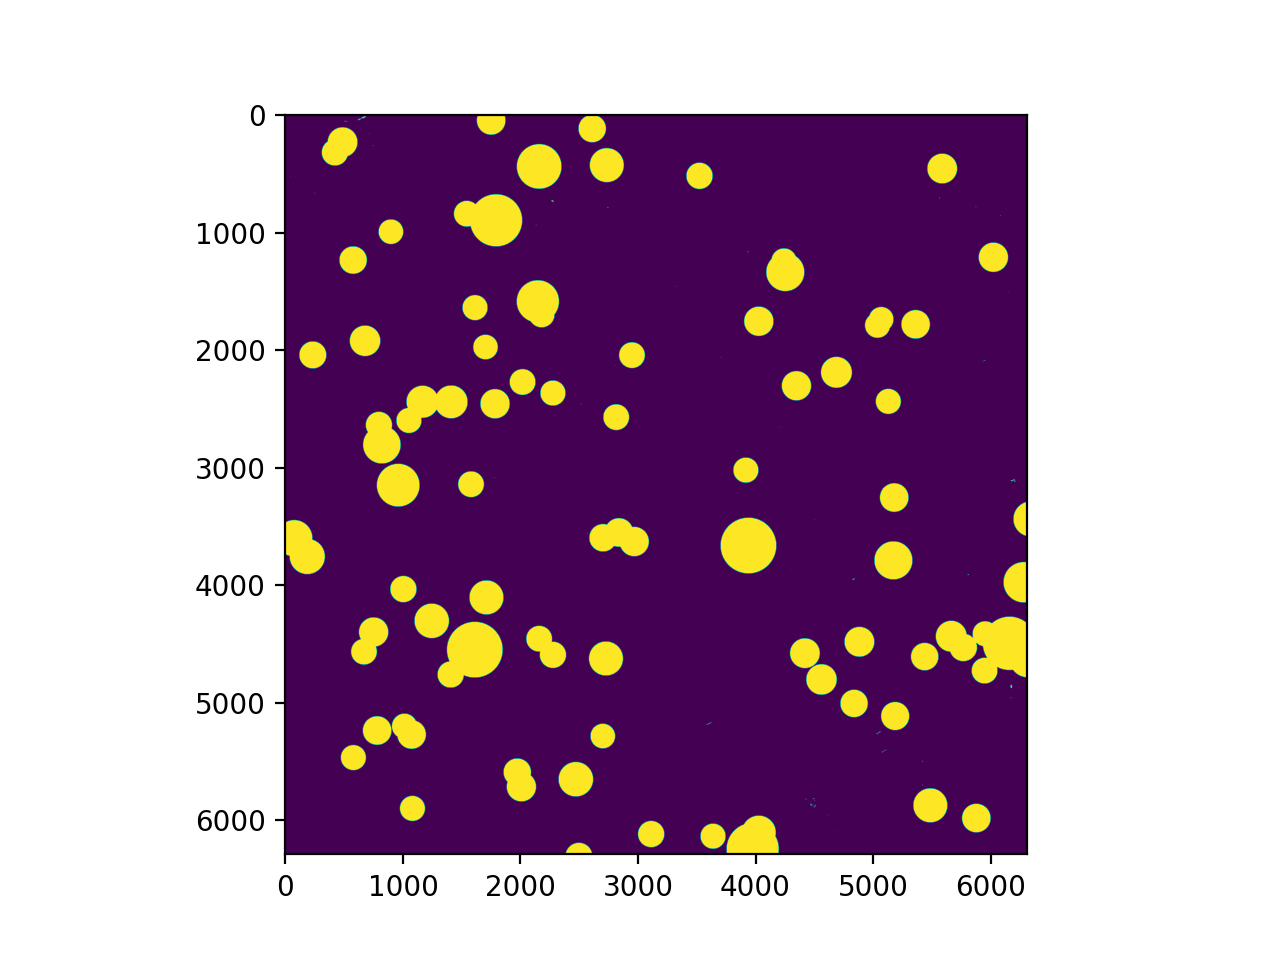

In [19]:
plt.figure()
plt.imshow(mask & 0x0080)

In [15]:
#ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
registrations = glob('../PS1_to_TESS/bulk_test_buffer/*.npy')
ps1_files = glob('../ps1_to_convolved/test/*.conv.fits')
#skycell_path = '../data/ps1_skycell/'
skycell_path = '../ps1_to_convolved/test/'


scene = np.zeros_like(tess_data)
mask_scene = np.zeros_like(tess_data)
for reg in registrations:
    ps1_assignment = np.load(reg).astype(int)
    skycell = reg.split('/')[-1].split('npy')[0]
    ps1_files = glob(skycell_path + skycell + 'stk.rizy.conv.fits' )
    print(ps1_files)
    if len(ps1_files) > 0:
        ps1 = ps1_data(ps1_files[0],mask=True,catalog=False)
        ps1_tess = ps1.padded
        pind = ps1_assignment.ravel()
        tess_pixels = np.unique(pind)[1:]
        start = time.time()
        pind = ps1_assignment.ravel()
        sort_ind = np.argsort(pind)
        ps1_tess_rav = ps1_tess.ravel()[sort_ind]
        mask_rav = ps1.mask.ravel()[sort_ind]
        breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
        breaks = np.insert(breaks,-1,len(ps1_tess_rav))

        sums = []
        msums = []
        for i in range(len(breaks)-1):
            # first entry is 0, which is not assigned, so we can skip it
            sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]
            msums += [np.bitwise_or.reduce(mask_rav[breaks[i]:breaks[i+1]])]
        
        scene[ty[tess_pixels],tx[tess_pixels]] = sums
        mask_scene[ty[tess_pixels],tx[tess_pixels]] = msums
        print('Time: %s' % (time.time()-start))
scene[scene == 0] = np.nan

    


['../ps1_to_convolved/test/rings.v3.skycell.2246.003.stk.rizy.conv.fits']



--2024-09-09 16:57:33--  http://ps1images.stsci.edu//rings.v3.skycell/2246/003/rings.v3.skycell.2246.003.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:33 ERROR 404: Not Found.



Time: 0.8068280220031738
['../ps1_to_convolved/test/rings.v3.skycell.2247.038.stk.rizy.conv.fits']



--2024-09-09 16:57:36--  http://ps1images.stsci.edu//rings.v3.skycell/2247/038/rings.v3.skycell.2247.038.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:36 ERROR 404: Not Found.



Time: 0.8249378204345703
['../ps1_to_convolved/test/rings.v3.skycell.2246.011.stk.rizy.conv.fits']



--2024-09-09 16:57:40--  http://ps1images.stsci.edu//rings.v3.skycell/2246/011/rings.v3.skycell.2246.011.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:40 ERROR 404: Not Found.



Time: 0.8390152454376221
['../ps1_to_convolved/test/rings.v3.skycell.2247.029.stk.rizy.conv.fits']



--2024-09-09 16:57:43--  http://ps1images.stsci.edu//rings.v3.skycell/2247/029/rings.v3.skycell.2247.029.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:43 ERROR 404: Not Found.



Time: 0.8048603534698486
['../ps1_to_convolved/test/rings.v3.skycell.2246.013.stk.rizy.conv.fits']



--2024-09-09 16:57:46--  http://ps1images.stsci.edu//rings.v3.skycell/2246/013/rings.v3.skycell.2246.013.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:46 ERROR 404: Not Found.



Time: 0.7536871433258057
['../ps1_to_convolved/test/rings.v3.skycell.2246.060.stk.rizy.conv.fits']



--2024-09-09 16:57:49--  http://ps1images.stsci.edu//rings.v3.skycell/2246/060/rings.v3.skycell.2246.060.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:49 ERROR 404: Not Found.



Time: 0.7544589042663574
['../ps1_to_convolved/test/rings.v3.skycell.2247.059.stk.rizy.conv.fits']



--2024-09-09 16:57:53--  http://ps1images.stsci.edu//rings.v3.skycell/2247/059/rings.v3.skycell.2247.059.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:53 ERROR 404: Not Found.



Time: 0.7642800807952881
['../ps1_to_convolved/test/rings.v3.skycell.2246.062.stk.rizy.conv.fits']



--2024-09-09 16:57:56--  http://ps1images.stsci.edu//rings.v3.skycell/2246/062/rings.v3.skycell.2246.062.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:56 ERROR 404: Not Found.



Time: 0.7522389888763428
['../ps1_to_convolved/test/rings.v3.skycell.2247.048.stk.rizy.conv.fits']



--2024-09-09 16:57:59--  http://ps1images.stsci.edu//rings.v3.skycell/2247/048/rings.v3.skycell.2247.048.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:57:59 ERROR 404: Not Found.



Time: 0.8209400177001953
['../ps1_to_convolved/test/rings.v3.skycell.2246.041.stk.rizy.conv.fits']



--2024-09-09 16:58:02--  http://ps1images.stsci.edu//rings.v3.skycell/2246/041/rings.v3.skycell.2246.041.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:02 ERROR 404: Not Found.



Time: 0.7633609771728516
['../ps1_to_convolved/test/rings.v3.skycell.2246.054.stk.rizy.conv.fits']



--2024-09-09 16:58:06--  http://ps1images.stsci.edu//rings.v3.skycell/2246/054/rings.v3.skycell.2246.054.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:06 ERROR 404: Not Found.



Time: 0.797982931137085
['../ps1_to_convolved/test/rings.v3.skycell.2246.042.stk.rizy.conv.fits']



--2024-09-09 16:58:09--  http://ps1images.stsci.edu//rings.v3.skycell/2246/042/rings.v3.skycell.2246.042.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:09 ERROR 404: Not Found.



Time: 0.8130011558532715
[]
['../ps1_to_convolved/test/rings.v3.skycell.2246.043.stk.rizy.conv.fits']



--2024-09-09 16:58:13--  http://ps1images.stsci.edu//rings.v3.skycell/2246/043/rings.v3.skycell.2246.043.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:13 ERROR 404: Not Found.



Time: 0.8193469047546387
['../ps1_to_convolved/test/rings.v3.skycell.2246.050.stk.rizy.conv.fits']



--2024-09-09 16:58:16--  http://ps1images.stsci.edu//rings.v3.skycell/2246/050/rings.v3.skycell.2246.050.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:16 ERROR 404: Not Found.



Time: 0.7899031639099121
['../ps1_to_convolved/test/rings.v3.skycell.2246.044.stk.rizy.conv.fits']



--2024-09-09 16:58:19--  http://ps1images.stsci.edu//rings.v3.skycell/2246/044/rings.v3.skycell.2246.044.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:19 ERROR 404: Not Found.



Time: 0.788179874420166
['../ps1_to_convolved/test/rings.v3.skycell.2247.069.stk.rizy.conv.fits']



--2024-09-09 16:58:23--  http://ps1images.stsci.edu//rings.v3.skycell/2247/069/rings.v3.skycell.2247.069.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:23 ERROR 404: Not Found.



Time: 0.8018670082092285
['../ps1_to_convolved/test/rings.v3.skycell.2246.051.stk.rizy.conv.fits']



--2024-09-09 16:58:26--  http://ps1images.stsci.edu//rings.v3.skycell/2246/051/rings.v3.skycell.2246.051.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:26 ERROR 404: Not Found.



Time: 0.7754008769989014
['../ps1_to_convolved/test/rings.v3.skycell.2246.022.stk.rizy.conv.fits']



--2024-09-09 16:58:29--  http://ps1images.stsci.edu//rings.v3.skycell/2246/022/rings.v3.skycell.2246.022.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:29 ERROR 404: Not Found.



Time: 0.7895660400390625
['../ps1_to_convolved/test/rings.v3.skycell.2247.027.stk.rizy.conv.fits']



--2024-09-09 16:58:33--  http://ps1images.stsci.edu//rings.v3.skycell/2247/027/rings.v3.skycell.2247.027.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:33 ERROR 404: Not Found.



Time: 0.7976009845733643
['../ps1_to_convolved/test/rings.v3.skycell.2247.018.stk.rizy.conv.fits']



--2024-09-09 16:58:36--  http://ps1images.stsci.edu//rings.v3.skycell/2247/018/rings.v3.skycell.2247.018.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:36 ERROR 404: Not Found.



Time: 0.800555944442749
['../ps1_to_convolved/test/rings.v3.skycell.2246.030.stk.rizy.conv.fits']



--2024-09-09 16:58:39--  http://ps1images.stsci.edu//rings.v3.skycell/2246/030/rings.v3.skycell.2246.030.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:39 ERROR 404: Not Found.



Time: 0.7781977653503418
['../ps1_to_convolved/test/rings.v3.skycell.2247.009.stk.rizy.conv.fits']



--2024-09-09 16:58:43--  http://ps1images.stsci.edu//rings.v3.skycell/2247/009/rings.v3.skycell.2247.009.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:43 ERROR 404: Not Found.



Time: 0.7956380844116211
['../ps1_to_convolved/test/rings.v3.skycell.2247.037.stk.rizy.conv.fits']



--2024-09-09 16:58:46--  http://ps1images.stsci.edu//rings.v3.skycell/2247/037/rings.v3.skycell.2247.037.stk.rizy.unconv.mask.fits
Resolving ps1images.stsci.edu (ps1images.stsci.edu)... 130.167.201.61
Connecting to ps1images.stsci.edu (ps1images.stsci.edu)|130.167.201.61|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-09-09 16:58:46 ERROR 404: Not Found.



Time: 0.8078000545501709


In [ ]:
for i in range(len(breaks)-1):

            msums += [np.bitwise_or.reduce(mask_rav[breaks[i]:breaks[i+1]])]

In [14]:
np.bitwise_or.reduce(mask_rav[:100])

8255

<IPython.core.display.Javascript object>


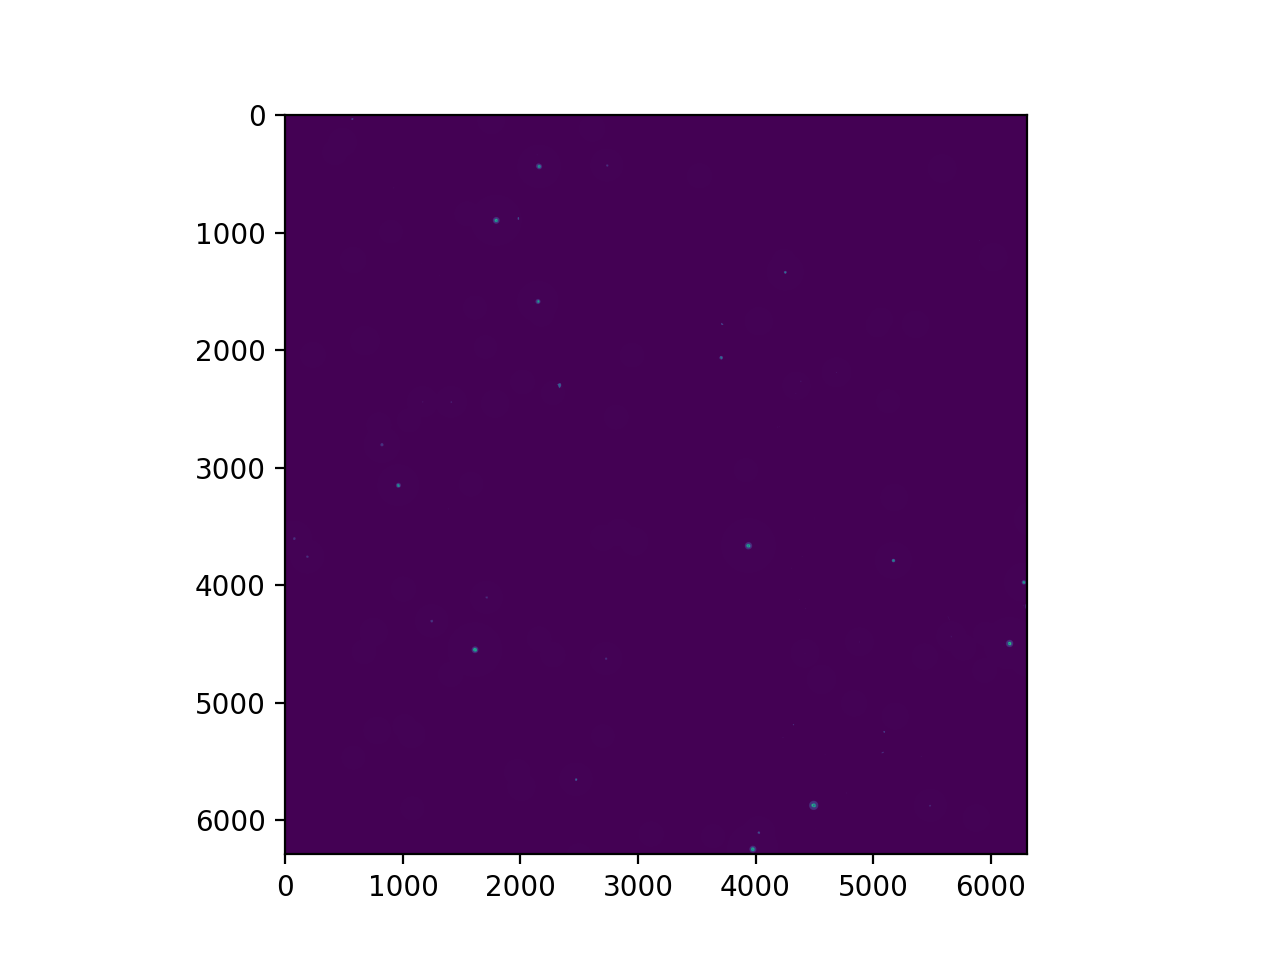

In [11]:
plt.figure()
plt.imshow(ps1.mask)

In [40]:
a = mask_scene.astype(int)

<IPython.core.display.Javascript object>


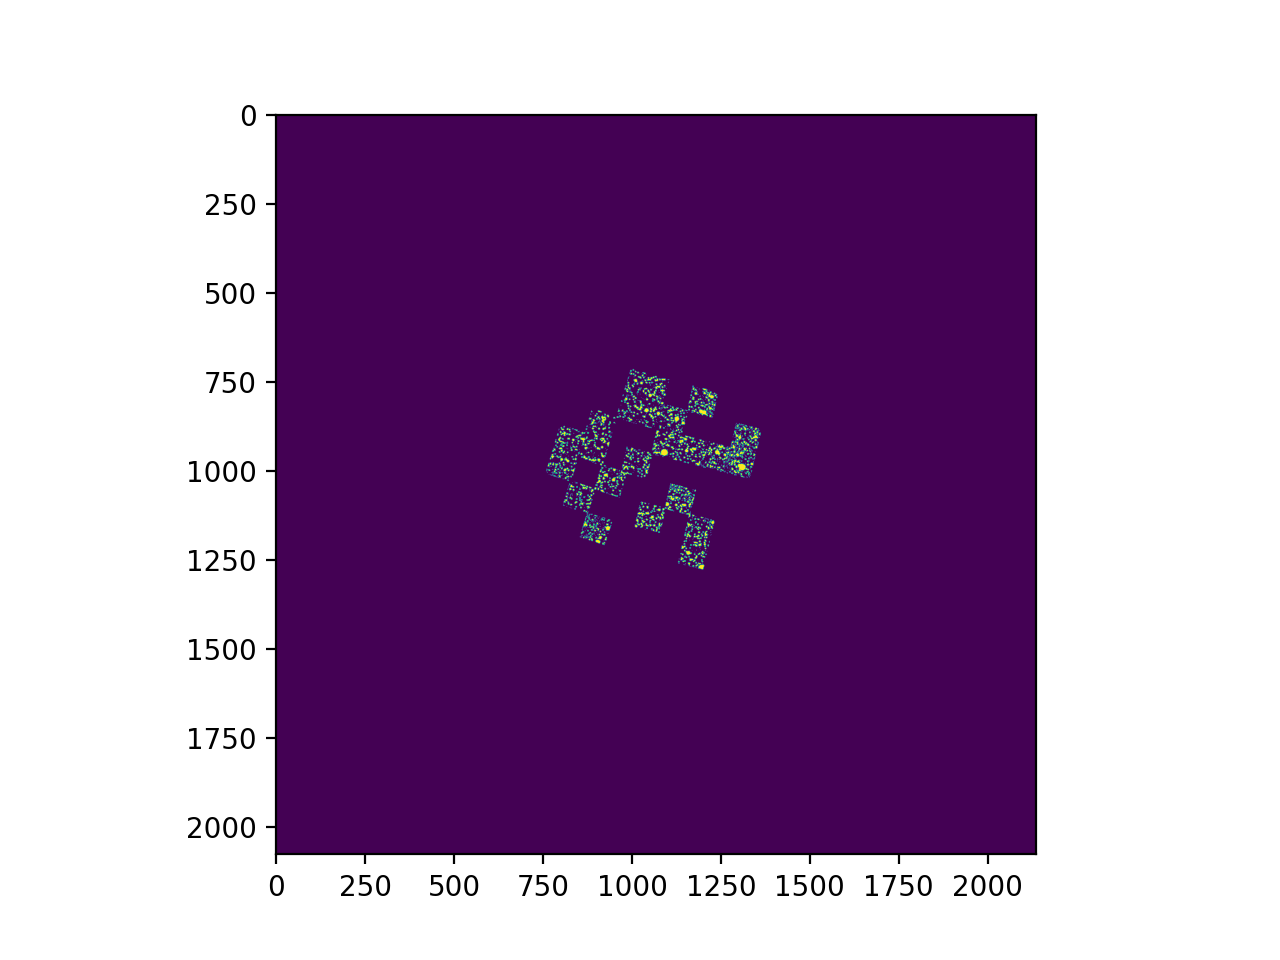

In [48]:
plt.figure()
plt.imshow(((a & 0x0080) > 0))

In [5]:
np.bitwise_or.reduce()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

<IPython.core.display.Javascript object>


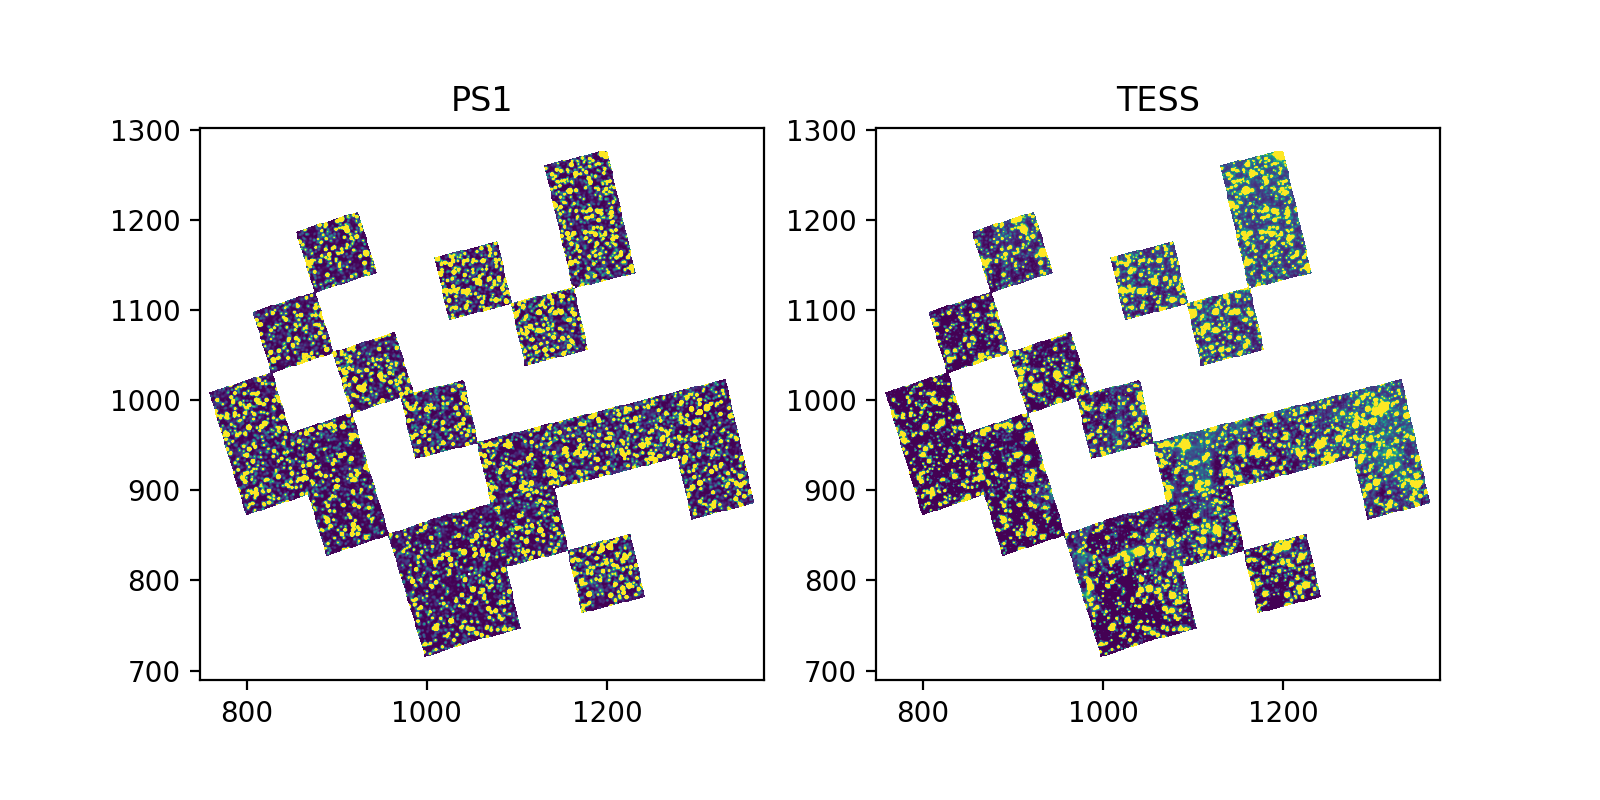

(689.0, 1303.0)

In [29]:
s = scene
#s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

xmin = np.min(np.where(np.isfinite(s))[1]) - 10
xmax = np.max(np.where(np.isfinite(s))[1]) + 10
ymin = np.min(np.where(np.isfinite(s))[0]) - 10
ymax = np.max(np.where(np.isfinite(s))[0]) + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [30]:
xc = (xmax + xmin ) /2 
yc = (ymax + ymin )/2
ra_, dec_ = tess_wcs.all_pix2world(xc,yc,0)

In [31]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

In [32]:
radius=Angle(abs(xmin-xc) * 21 + 60, unit = u.arcsecond)

In [33]:
cat = pd.read_csv('/Users/rri38/Downloads/syndiff_test_field_rridden.csv')
_tx,_ty = tess_wcs.all_world2pix(cat.raMean,cat.decMean,0)
cat['tessx'] = _tx; cat['tessy'] = _ty
cat = PS1_to_TESS_mag(cat)

sub = cat.loc[(cat.iMeanPSFMag < 17) ]# & (cat.rMeanPSFMag > 12)
#sub = cat.loc[(cat.tmag < 14) & np.isfinite(cat.tmag)  & (cat.rMeanPSFMag > 14)]
ind = ((sub.tessy.values>2) & (sub.tessy.values<tess_data.shape[0]-2) &
       (sub.tessx.values>2) & (sub.tessx.values<tess_data.shape[1]-2))

sub = sub.loc[ind]

subsub = sub.iMeanPSFMag.values >14

In [34]:
scale = 21/0.25
ap_size = 1.5
pos = list(zip(sub.tessx, sub.tessy))
taperture = CircularAperture(pos, ap_size)
a = t
#m,med,std = sigma_clipped_stats(a)
tphot_table = aperture_photometry(a, taperture)
#tphot_table = aperture_photometry(tess.ref, taperture)


pphot_table = aperture_photometry(scene, taperture)

ptmag = -2.5*np.log10(pphot_table['aperture_sum'].value)
tmag = -2.5*np.log10(tphot_table['aperture_sum'].value)
ind = np.isfinite(tmag) & np.isfinite(ptmag)

ptmag = ptmag[ind]
tmag = tmag[ind]

In [35]:
subsub = (tmag >-12) & (tmag < -9)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1,fixed={'slope': True})
line_flexi = models.Linear1D(slope=1)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tmag[subsub], ptmag[subsub])
flexi_line, mask = or_fit(line_flexi, tmag[subsub], ptmag[subsub])
filtered_data = np.ma.masked_array(ptmag[subsub], mask=mask)

<IPython.core.display.Javascript object>


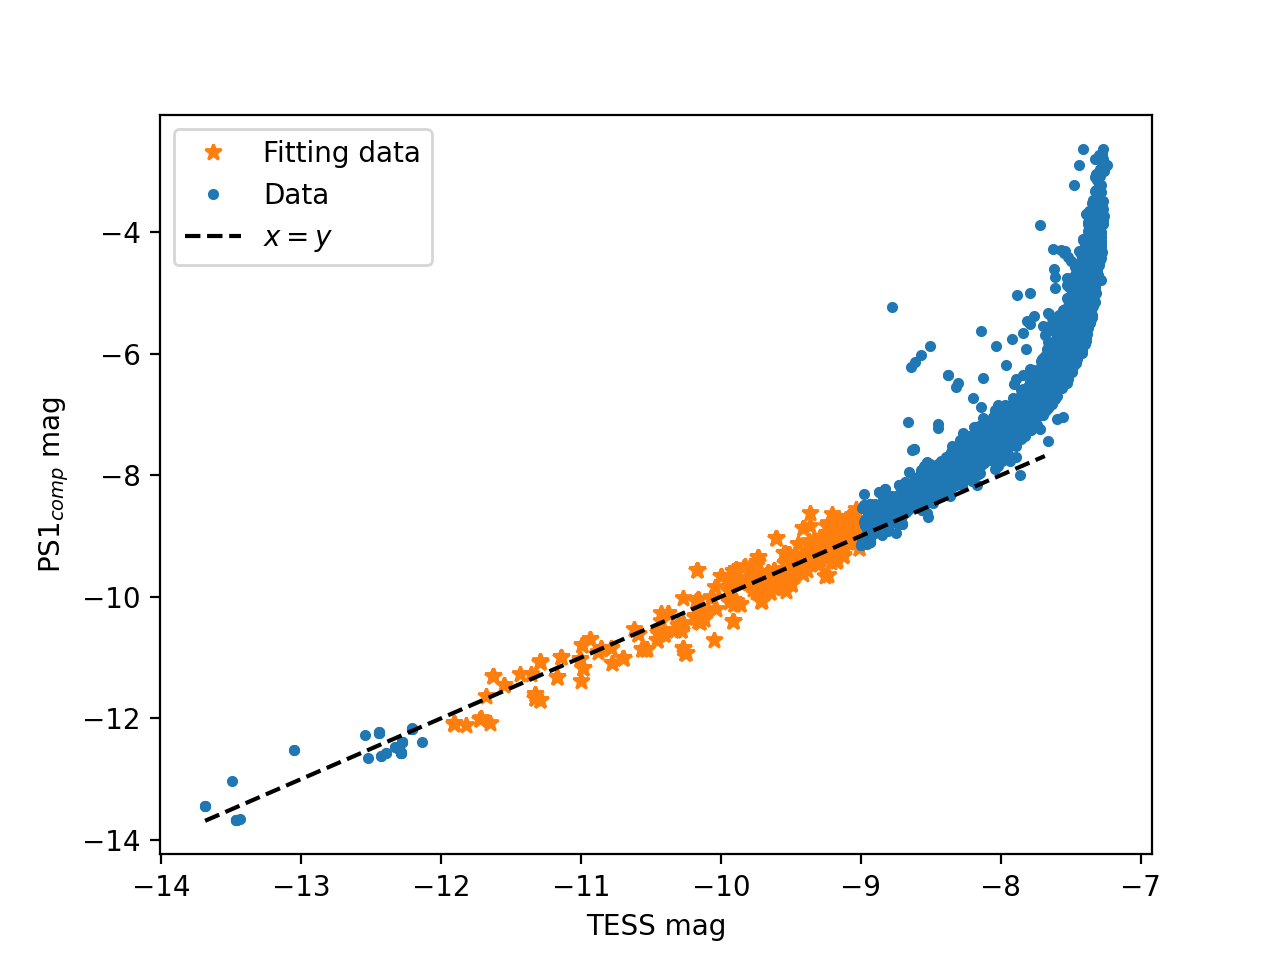

In [36]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


In [37]:
ind2 = (tmag < -8.5) & (tmag > -10)

In [38]:
test = np.nanmedian(pphot_table['aperture_sum'].value[ind][ind2]/ tphot_table['aperture_sum'].value[ind][ind2])


<IPython.core.display.Javascript object>


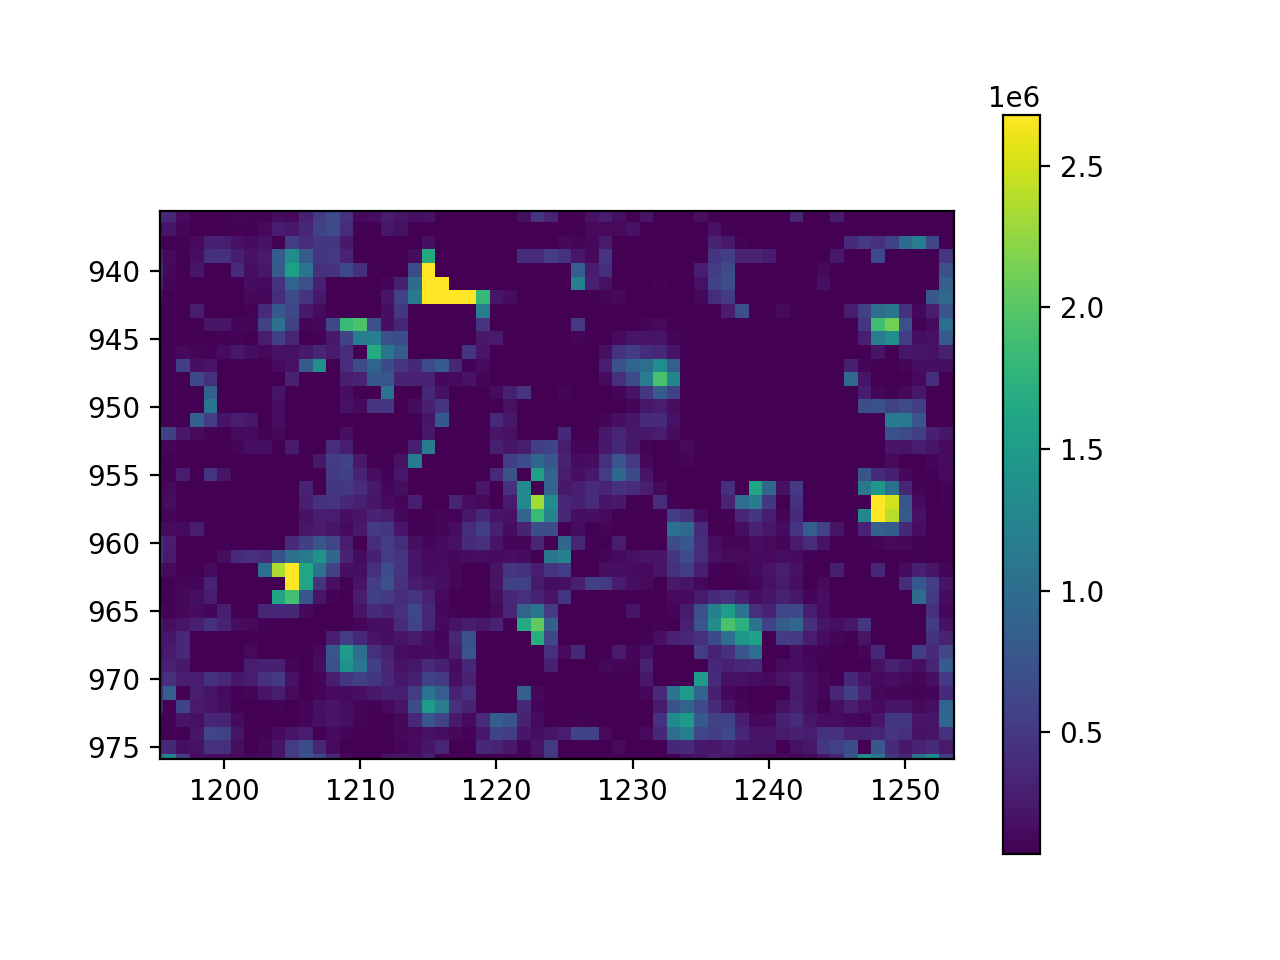

In [46]:
m,med,std = sigma_clipped_stats(t)
diff = s#(t-med+10) - (s/test)
vmax = np.nanpercentile(diff,90)
#vmax = 20
#
vmin = np.nanpercentile(diff,16)#-20
plt.figure()

plt.imshow(((a & 0x0080) == 0) *diff,vmin=vmin,vmax=vmax)
plt.colorbar()

## Fit fluxes

In [13]:
subsub = (tphot_table['aperture_sum'].value[ind] >1100)
fit = fitting.LinearLSQFitter()

# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=3.0)

# initialize a linear model
line_init = models.Linear1D(slope=1)


# fit the data with the fitter
fitted_line, mask = or_fit(line_init, tphot_table['aperture_sum'].value[ind][subsub], pphot_table['aperture_sum'].value[ind][subsub])
filtered_data = np.ma.masked_array(pphot_table['aperture_sum'].value[ind][subsub], mask=mask)

<IPython.core.display.Javascript object>


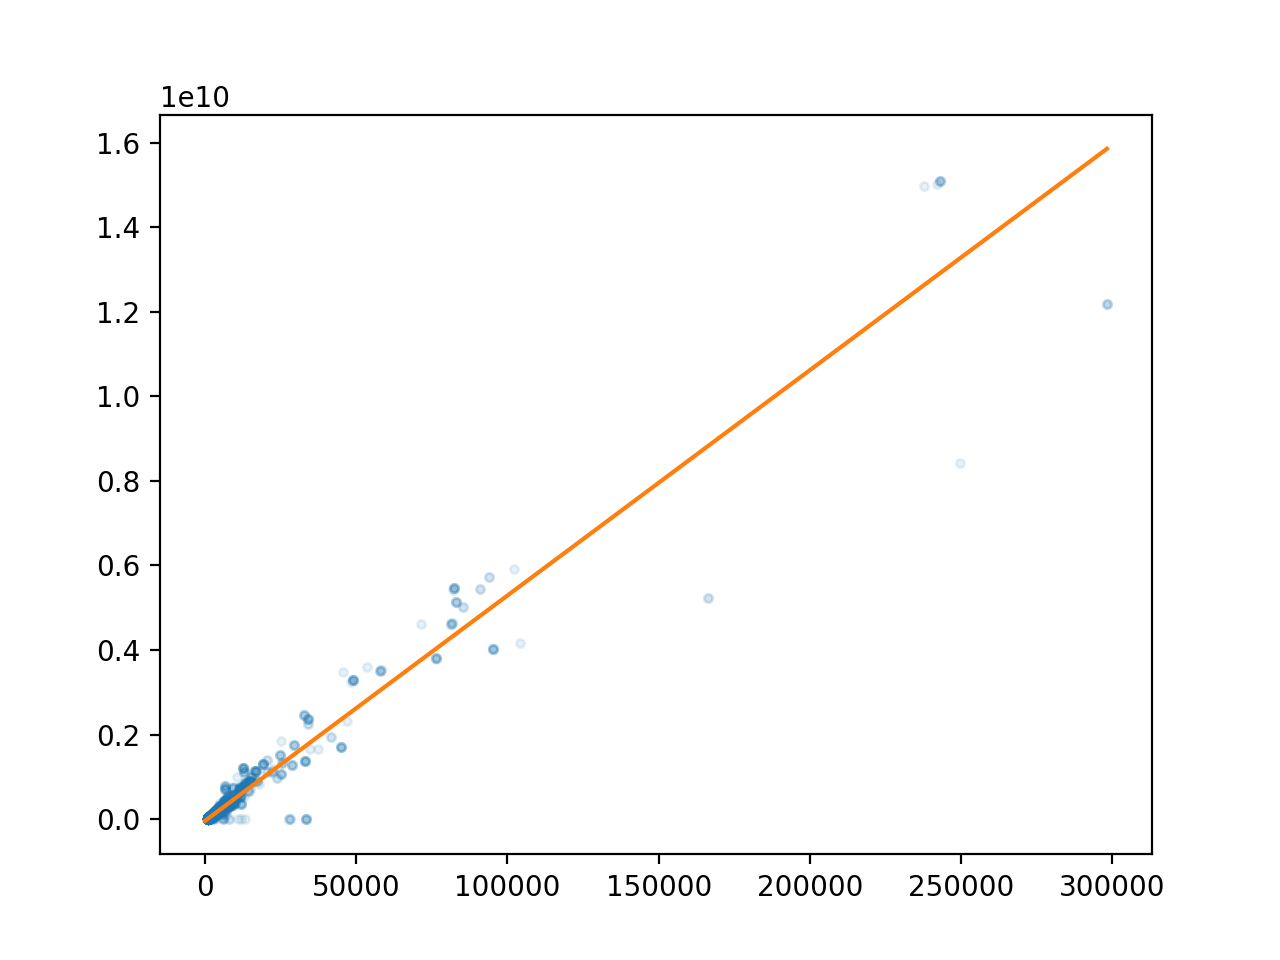

In [14]:
x = np.arange(0,np.nanmax(tphot_table['aperture_sum'].value))
plt.figure()
plt.plot(tphot_table['aperture_sum'].value,pphot_table['aperture_sum'].value,'.',alpha=0.1)
plt.plot(x,fitted_line(x))

In [ ]:
x = np.arange(min(tmag),max(tmag))
plt.figure()
plt.plot(tmag[subsub], filtered_data - fitted_line.parameters[1], "C1*", label="Fitting data")
#plt.plot(tmag, ptmag,"C1o", fillstyle="none", label="Clipped")
plt.plot(tmag[~subsub], ptmag[~subsub] - fitted_line.parameters[1], "C0.", label="Data")
plt.plot(x, fitted_line(x)- fitted_line.parameters[1], 'k--', label=r'$x=y$')
#plt.plot(x,flexi_line(x)- fitted_line.parameters[1],'C1--', label=f'Model, m={np.round(flexi_line.parameters[0],2)}')
plt.xlabel('TESS mag')
plt.ylabel(r'PS1$_{comp}$ mag')
#plt.xlim(11,17)
#plt.ylim(11,17)
plt.legend()
#plt.savefig('ps1_tess_magcomparison.png')


In [65]:
tind = tmag > -5

## test shifting 

In [106]:
from scipy.ndimage import shift

In [107]:
ps1_files = glob('../data/ps1_skycell/*.unconv.satcor.fits')
registrations = glob('../PS1_to_TESS/bulk_test_buffer/*.npy')
skycell_path = '../data/ps1_skycell/'

offset = [20,-5]
scenes = []
for reg in registrations:
    ps1_assignment = shift(np.load(reg).astype(int),offset)
    skycell = reg.split('/')[-1].split('npy')[0]
    ps1_files = glob(skycell_path + skycell + '*.unconv.satcor.fits' )
    ps1 = {}
    for file in ps1_files:
        hdu = fits.open(file)
        header = hdu[0].header

        data = image2counts(hdu[0].data,header)
        m,med,std = sigma_clipped_stats(data)
        ps1[file.split('stk.')[1].split('.unconv')[0]] = data-med
    #ps1_wcs = WCS(header)

    noconvps1_tess = 0.238*ps1['r'] + 0.344*ps1['i'] + 0.283*ps1['z'] + 0.135*ps1['y']
    ps1_tess = sd.signal.fftconvolve(noconvps1_tess, psfg, mode='same')
    # assign values 
    pind = ps1_assignment.ravel()
    tess_pixels = np.unique(pind)[1:]
    start = time.time()
    pind = ps1_assignment.ravel()
    sort_ind = np.argsort(pind)
    ps1_tess_rav = ps1_tess.ravel()[sort_ind]
    breaks = np.where(np.diff(pind[sort_ind])> 0)[0]
    breaks = np.insert(breaks,-1,len(ps1_tess_rav))

    sums = []
    for i in range(len(breaks)-1):
        # first entry is 0, which is not assigned, so we can skip it
        sums += [np.sum(ps1_tess_rav[breaks[i]:breaks[i+1]])]

    s = np.zeros_like(tess_data)
    s[ty[tess_pixels],tx[tess_pixels]] = sums
    print('Time: %s' % (time.time()-start))
    scenes += [s]
scenes = np.array(scenes)
scenes[scenes == 0] = np.nan
shift_scene = np.nanmedian(scenes,axis=0)
    


Time: 0.7693719863891602
Time: 0.7717618942260742
Time: 0.7549450397491455
Time: 0.7814631462097168
Time: 0.7405450344085693
Time: 0.7478351593017578
Time: 0.7970221042633057
Time: 0.7581372261047363
Time: 0.8233411312103271
Time: 0.7687380313873291
Time: 0.7542212009429932
Time: 0.7880859375
Time: 0.7575969696044922
Time: 0.7891530990600586
Time: 0.7408151626586914
Time: 0.7379031181335449
Time: 0.7630822658538818
Time: 0.7362058162689209
Time: 0.7396719455718994
Time: 0.7848689556121826
Time: 0.7649111747741699
Time: 0.7507390975952148
Time: 0.7522313594818115
Time: 0.7555460929870605


In [113]:
20*0.25/21


0.23809523809523808

<IPython.core.display.Javascript object>


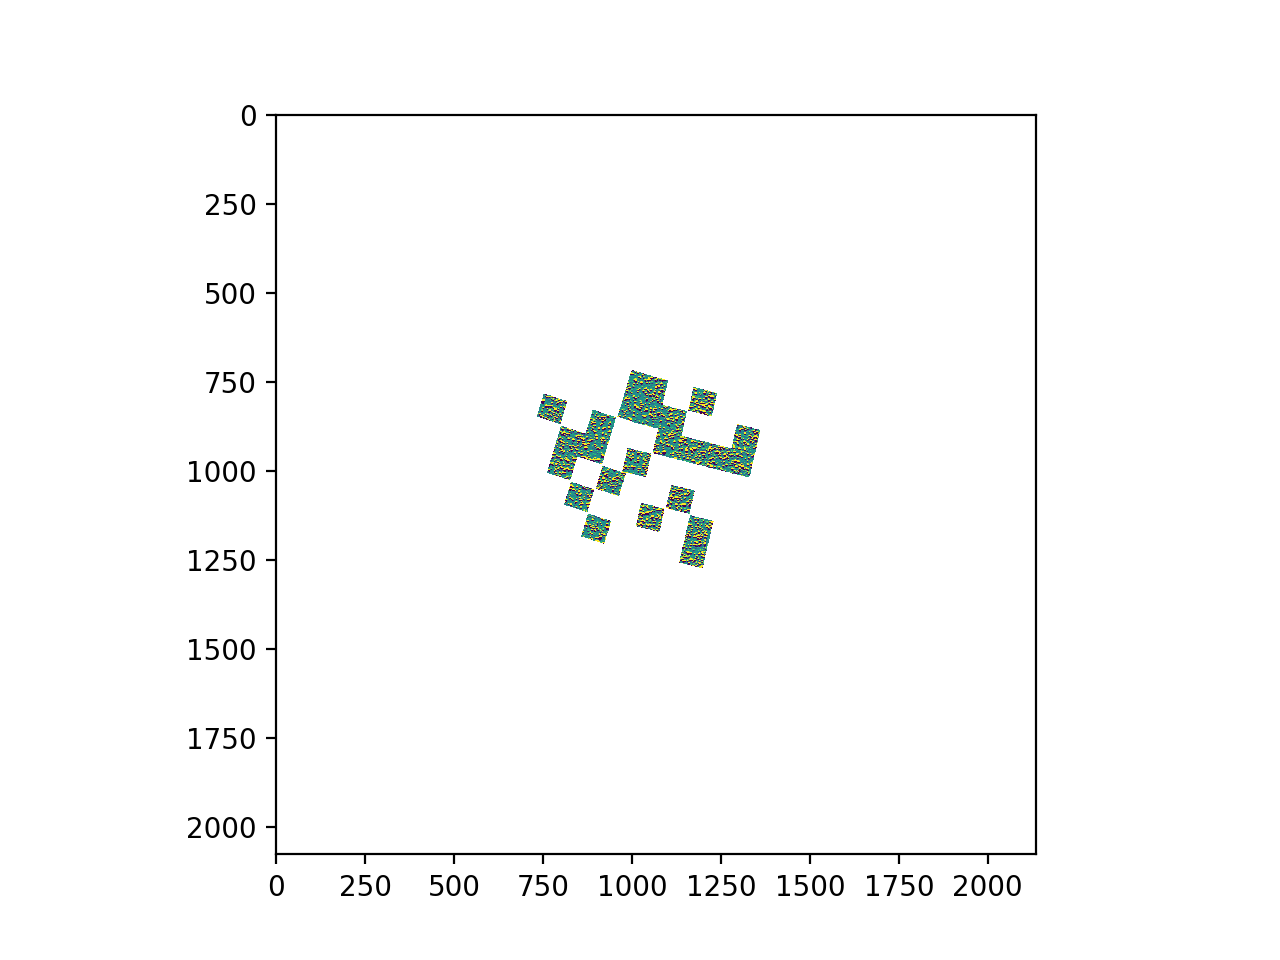

In [111]:
diff =scene-shift_scene
vmin = np.nanpercentile(diff,16)
vmax = np.nanpercentile(diff,84)
plt.figure()
plt.imshow(diff,vmin=vmin,vmax=vmax)

In [66]:
question = tphot_table[ind][tind]

<IPython.core.display.Javascript object>


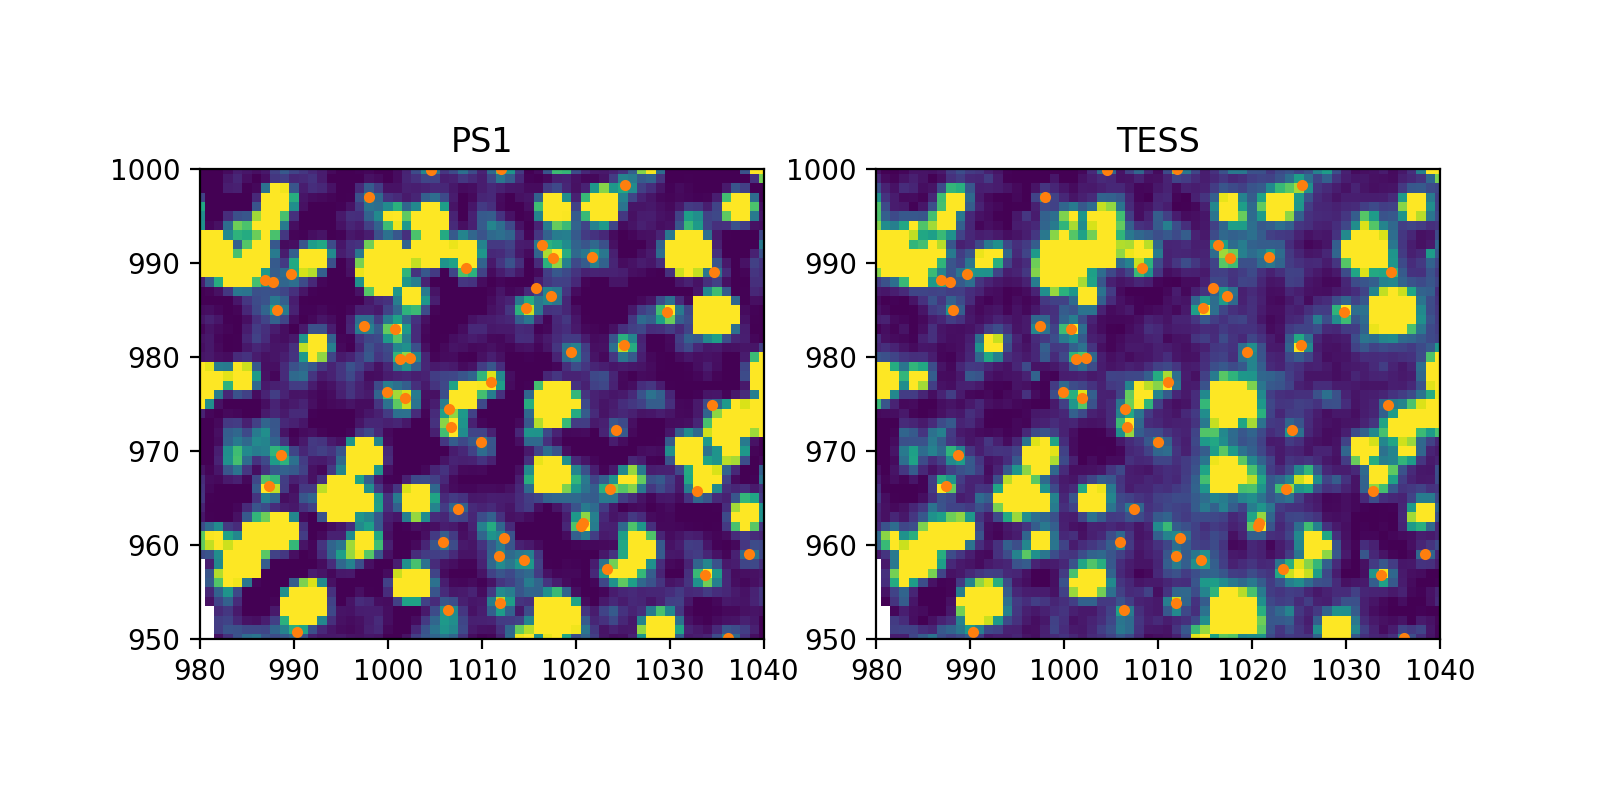

In [79]:
xmin = np.min(np.where(np.isfinite(s))[1]) - 10
xmax = np.max(np.where(np.isfinite(s))[1]) + 10
ymin = np.min(np.where(np.isfinite(s))[0]) - 10
ymax = np.max(np.where(np.isfinite(s))[0]) + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
plt.xlim(980,1040)
plt.ylim(950,1000)
plt.plot(question['xcenter'],question['ycenter'],'C1.')
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
plt.xlim(980,1040)
plt.ylim(950,1000)
plt.plot(question['xcenter'],question['ycenter'],'C1.')

<IPython.core.display.Javascript object>


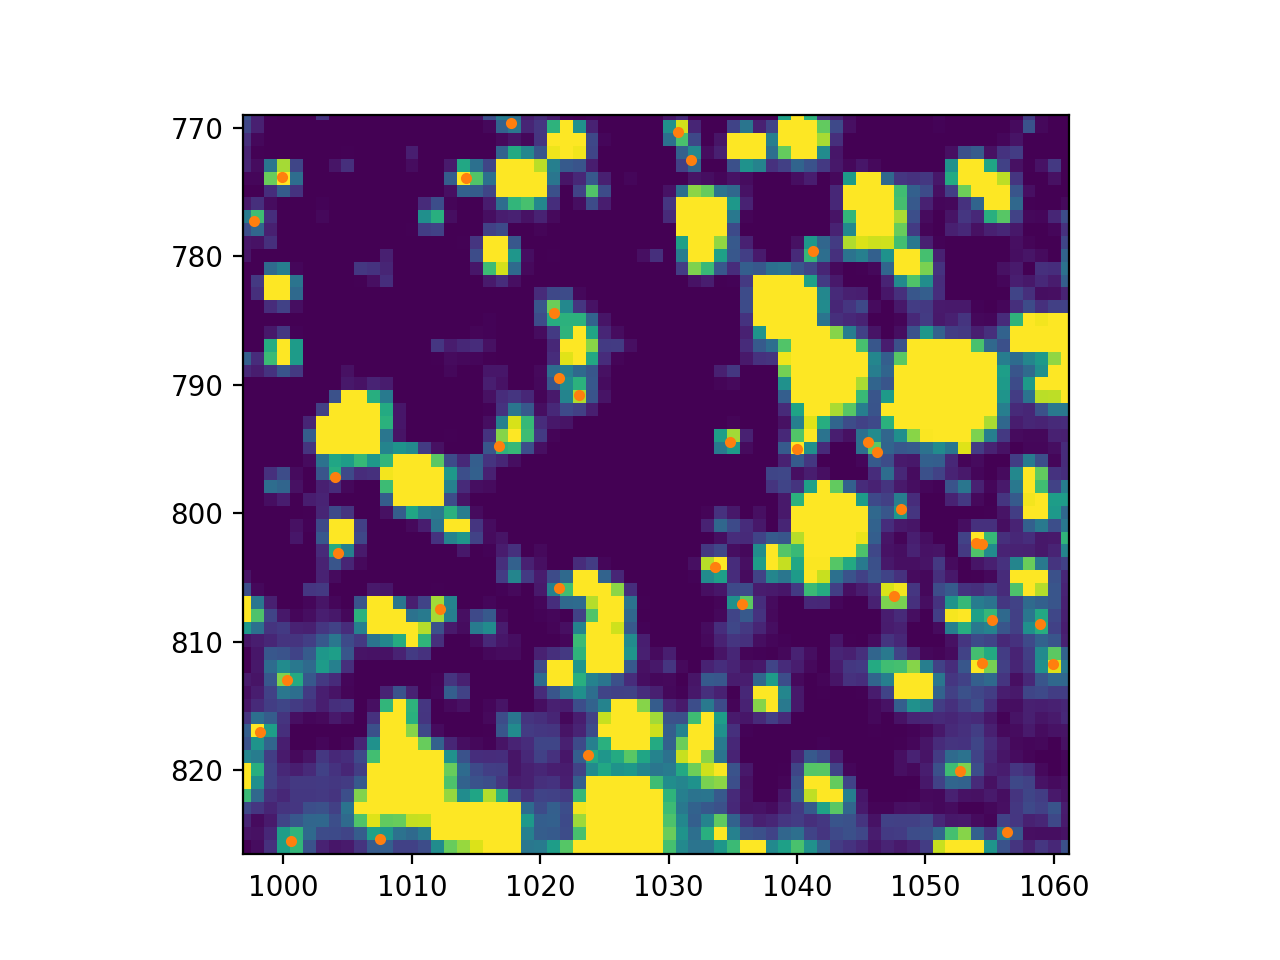

In [60]:
plt.figure()
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.plot(question['xcenter'],question['ycenter'],'C1.')

In [118]:
import tessvectors
vector = tessvectors.getvector(("FFI", 20, 1))

INFO:root:Retrieving TESSVector from: https://heasarc.gsfc.nasa.gov/docs/tess/data/TESSVectors/Vectors/FFI_Cadence/TessVectors_S020_C1_FFI.xz


<IPython.core.display.Javascript object>


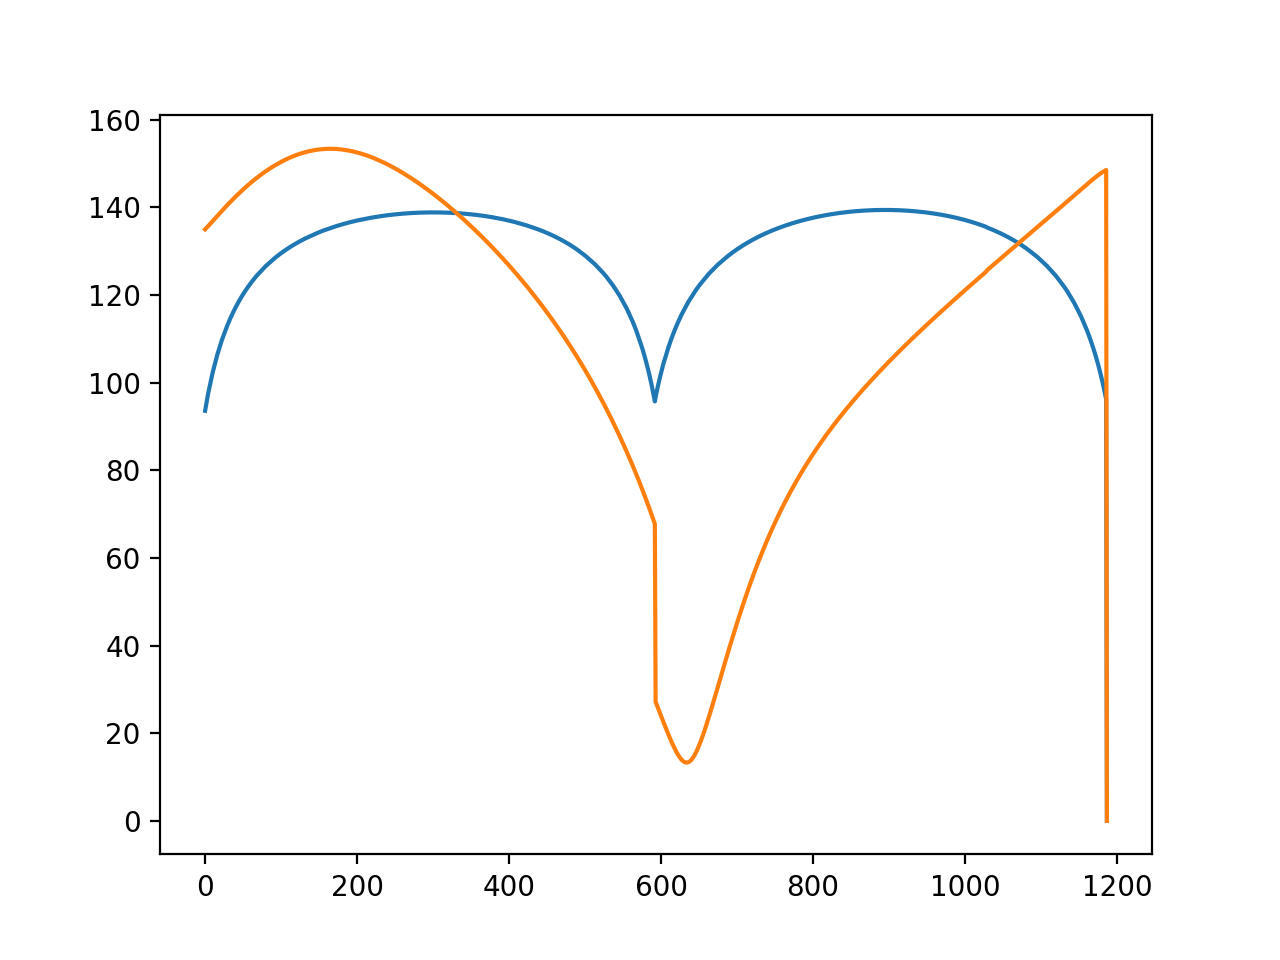

In [123]:
plt.figure()
plt.plot(vector['Cadence'],vector['Earth_Camera_Angle'])
plt.plot(vector['Cadence'],vector['Moon_Camera_Angle'])

In [135]:
np.argsort(vector['Earth_Camera_Angle'].values + vector['Moon_Camera_Angle'].values)[::-1]

array([ 196,  197,  195, ...,  594,  593, 1187])

In [129]:
np.where((vector['Earth_Camera_Angle'].values > 120) & (vector['Moon_Camera_Angle'].values > 120))

(array([  50,   51,   52,   53,   54,   55,   56,   57,   58,   59,   60,
          61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
          72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,
          83,   84,   85,   86,   87,   88,   89,   90,   91,   92,   93,
          94,   95,   96,   97,   98,   99,  100,  101,  102,  103,  104,
         105,  106,  107,  108,  109,  110,  111,  112,  113,  114,  115,
         116,  117,  118,  119,  120,  121,  122,  123,  124,  125,  126,
         127,  128,  129,  130,  131,  132,  133,  134,  135,  136,  137,
         138,  139,  140,  141,  142,  143,  144,  145,  146,  147,  148,
         149,  150,  151,  152,  153,  154,  155,  156,  157,  158,  159,
         160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,
         171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,
         182,  183,  184,  185,  186,  187,  188,  189,  190,  191,  192,
         193,  194,  195,  196,  197, 

In [124]:
ind = np.argmax(vector['Earth_Camera_Angle']+ vector['Moon_Camera_Angle'])

196

In [128]:
np.where('tess2019360165923-s0020-1-{ccd}-0165-s_ffic.fits' == vector['FFIFile'].values)

(array([82]),)

In [ ]:
tess2019360165923-s0020-1-{ccd}-0165-s_ffic.fits

In [120]:
vector['Cadence']

Cadence      MidTime  Segment   Quat_Start    Quat_Stop  Quat_MIN_FOM  \
0         0.0  1842.510779      1.0  1842.500384  1842.521171         236.0   
1         1.0  1842.531591      1.0  1842.521194  1842.541981         236.0   
2         2.0  1842.552464      1.0  1842.542074  1842.562861         236.0   
3         3.0  1842.573276      1.0  1842.562884  1842.583671         236.0   
4         4.0  1842.594150      1.0  1842.583763  1842.604550         236.0   
...       ...          ...      ...          ...          ...           ...   
1183   1183.0  1868.719106      2.0  1868.708706  1868.729493         224.0   
1184   1184.0  1868.739919      2.0  1868.729516  1868.750303         224.0   
1185   1185.0  1868.760732      2.0  1868.750326  1868.771137         224.0   
1186   1186.0  1868.781607      2.0  1868.771206  1868.791993         224.0   
1187   1187.0  1868.802420      2.0     0.000000     0.000000           0.0   

      Quat_MIN_NUM_GSUSED  Quat_NBinned  Quat1_Med  Quat1_StdDev  ...  \
0                   199.0         899.0  -0.000004      0.000003  ...   
1                   198.0         899.0  -0.000004      0.000004  ...   
2                   199.0         899.0  -0.000004      0.000003  ...   
3                   199.0         899.0  -0.000004      0.000005  ...   
4                   198.0         899.0  -0.000003      0.000004  ...   
...                   ...           ...        ...           ...  ...   
1183                199.0         899.0   0.000001      0.000002  ...   
1184                199.0         899.0   0.000001      0.000002  ...   
1185                199.0         900.0   0.000001      0.000003  ...   
1186                198.0         899.0   0.000001      0.000003  ...   
1187                  0.0           0.0   0.000000      0.000000  ...   

      Earth_Camera_Angle  Earth_Camera_Azimuth  Moon_Distance  \
0              93.571940             84.308388      71.309429   
1              94.588146             85.213408      71.828868   
2              95.567489             86.088988      72.340161   
3              96.511821             86.937118      72.843504   
4              97.482490             87.813567      73.371856   
...                  ...                   ...            ...   
1183           98.747944            258.688097      51.923704   
1184           97.942838            259.402784      51.667893   
1185           97.112742            260.135607      51.413049   
1186           96.256543            260.887651      51.159474   
1187            0.000000              0.000000       0.000000   

      Moon_Camera_Angle  Moon_Camera_Azimuth  Earth_Spacecraft_Angle  \
0            134.971346           108.509240               -6.233661   
1            135.154069           108.796743               -6.523242   
2            135.338890           109.087187               -6.799296   
3            135.525517           109.380339               -7.062588   
4            135.726280           109.695787               -7.330178   
...                 ...                  ...                     ...   
1183         148.236733           140.127727               -0.520767   
1184         148.337996           139.706407               -0.271314   
1185         148.433991           139.262395               -0.014418   
1186         148.524242           138.794985                0.250192   
1187           0.000000             0.000000                0.000000   

      Earth_Spacecraft_Azimuth  Moon_Spacecraft_Angle  \
0                   267.494098             -26.089011   
1                   268.830425             -26.106424   
2                   270.121145             -26.124943   
3                   271.368729             -26.144467   
4                   272.654536             -26.166297   
...                        ...                    ...   
1183                 75.744708             -26.768249   
1184                 76.786840             -26.953905   
1185                 

In [121]:
tess_pixels = np.unique(pind)[1:]

In [112]:
tess_pixels.shape

(5906,)

In [99]:
breaks = np.where(np.diff(pind[sort_ind])> 0)[0]

In [104]:
len(np.unique(pind))

5907

In [101]:
len(pind[breaks])

5906

In [90]:
breaks

array([       0,   248971,   254576, ..., 39653333, 39664723, 39660121])

In [92]:
np.nansum(ps1_tess_raw[breaks[0]:breaks[1]])

178772633.6239983

In [97]:
pind[sort_ind][breaks]

IndexError: index 39664723 is out of bounds for axis 0 with size 39664723

[178772633.6239983,
 5534471.056222131,
 5636598.017043559,
 4481199.96953631,
 6182852.444745507,
 6307785.1092449045,
 5953101.905306262,
 5938109.3171606865,
 5789457.8181391,
 923599.2854661944,
 9663851.242063113,
 6057780.0766408155,
 6091083.987087073,
 6129994.264734541,
 6387582.966625285,
 6707204.022983358,
 6847034.5978176985,
 5588043.8212004285,
 971495.6628104325,
 6280438.61259209,
 6400193.012507018,
 6409205.663768269,
 6449427.901545408,
 6501707.156079311,
 6889051.051285716,
 11136946.383422513,
 6633405.044960437,
 6650120.064795751,
 6679006.224584864,
 6867705.626694897,
 6578667.742116762,
 1565931.3981139243,
 6768509.53895605,
 6815419.589902351,
 6859038.301982798,
 10513142.060239535,
 8470731.226845663,
 6926395.699822023,
 6945326.422525672,
 6964589.311733127,
 7541639.662929291,
 7586147.027283917,
 7237911.165868665,
 7147971.161786325,
 7091846.120447006,
 7074862.177785213,
 7079009.88616381,
 5617175.448195346,
 7116425.877249092,
 7126817.990454563

In [70]:
max(tx)

2135

In [71]:
t_x

2136

In [72]:
start = time.time()
scene = np.zeros_like(tess_data)
#  range(1000):#
for i in range(len(pind)):
    scene[ty[pind[i]],tx[pind[i]]] += ps1_tess[py[i],px[i]]
print('Time: %s' % (time.time()-start))

Time: 37.14375281333923


In [73]:
np.any(scene)

True

<IPython.core.display.Javascript object>


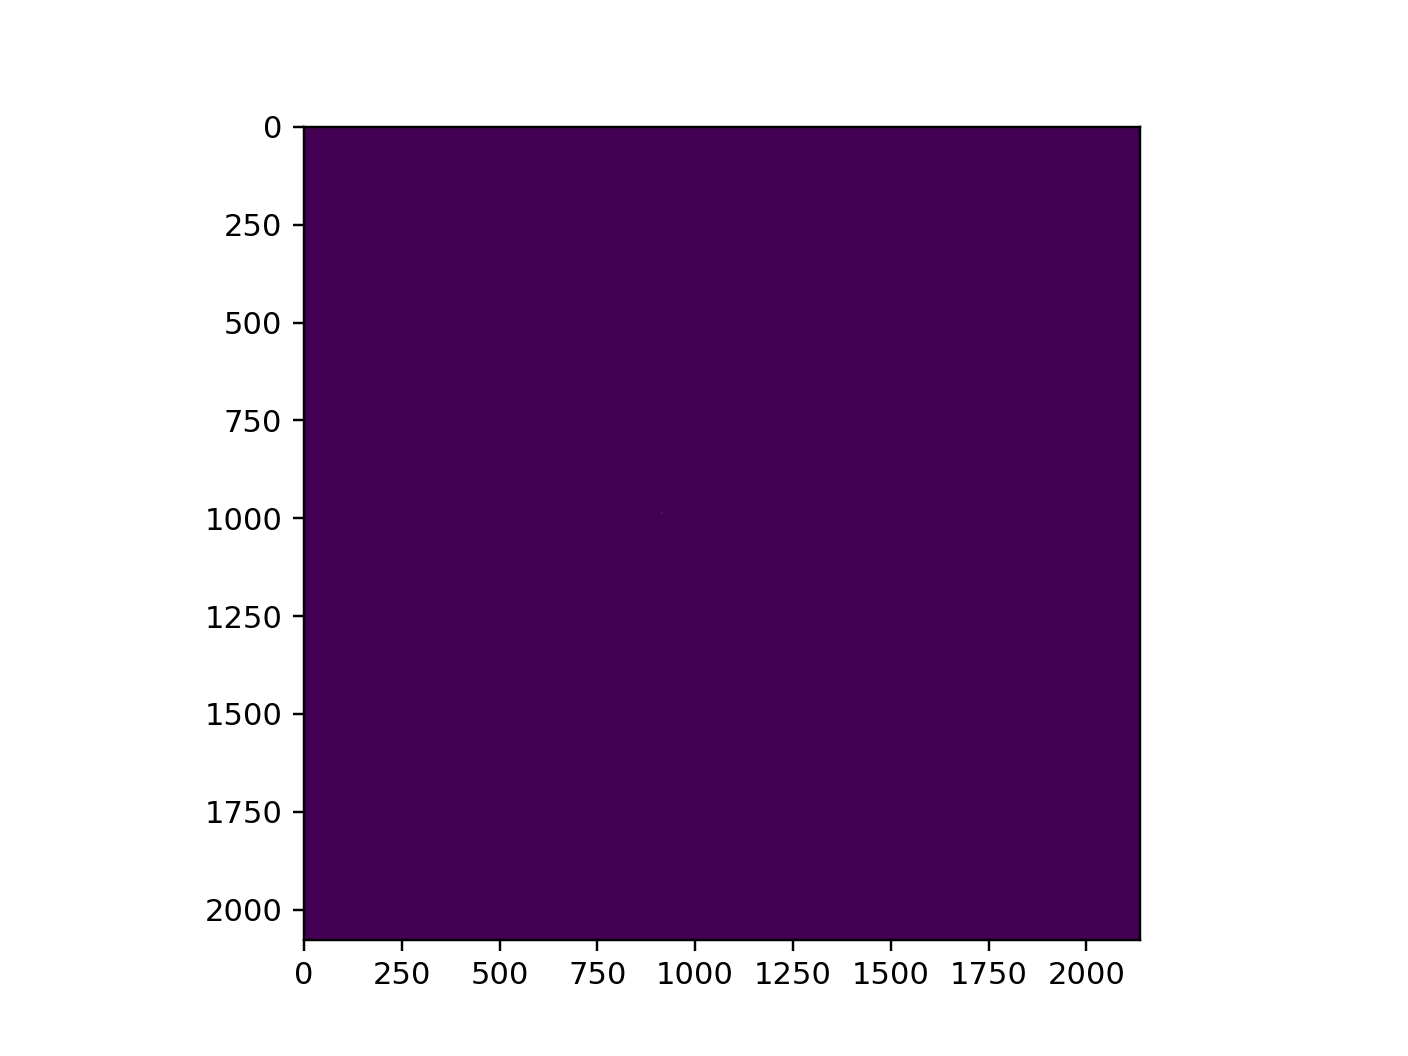

In [57]:
plt.figure()
plt.imshow(scene)

In [17]:
scene = np.zeros_like(tess_data)

for ind in assigned_tess:
    
    scene[ty[ind],tx[ind]] = np.sum(ps1_tess[ps1_assignment == ind])

KeyboardInterrupt: 

In [74]:
s = deepcopy(scene)
s[s==0] = np.nan
t = deepcopy(tess_data)
t[np.isnan(s)] = np.nan

In [75]:
np.nansum(s > 0)

5469

In [76]:
yint,xint = np.where(np.isfinite(s))


<IPython.core.display.Javascript object>


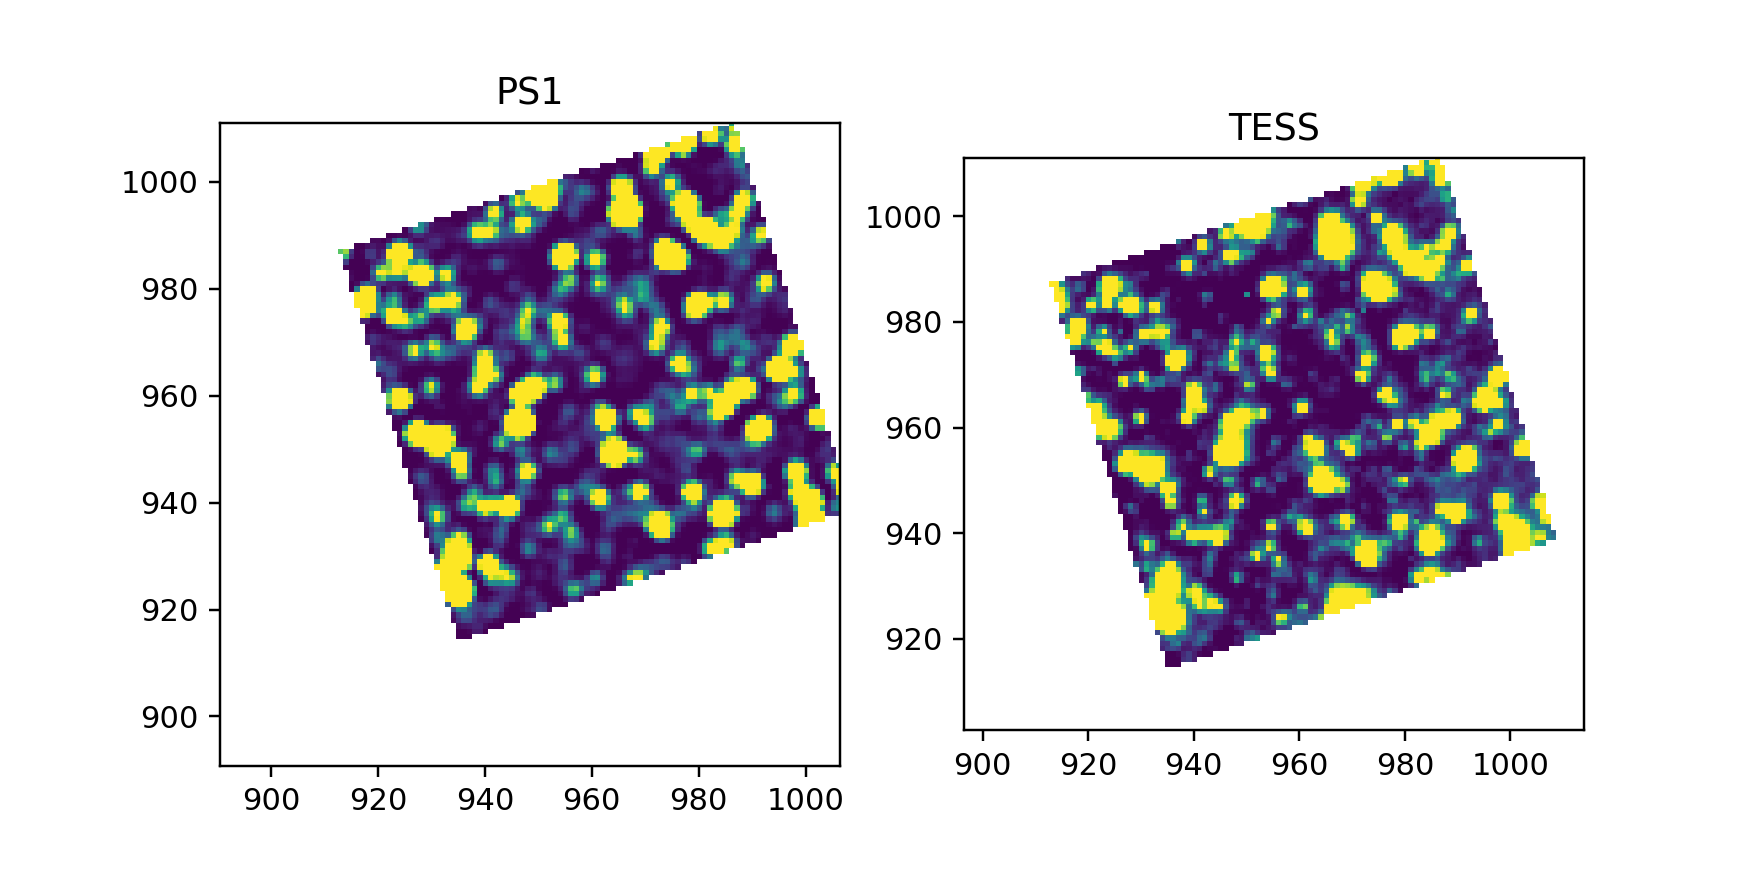

(-25.0, 1011.0)

In [78]:
xmin = np.where(np.isfinite(s))[0][0] - 10
xmax = np.where(np.isfinite(s))[0][-1] + 10
ymin = np.where(np.isfinite(s))[1][0] - 10
ymax = np.where(np.isfinite(s))[1][-1] + 10

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PS1')
vmin = np.nanpercentile(s,16)
vmax = np.nanpercentile(s,84)
plt.imshow(s,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.xlim(1020,1120)
#plt.ylim(1015,1115)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)
plt.subplot(122)
plt.title('TESS')
vmin = np.nanpercentile(t,16)
vmax = np.nanpercentile(t,84)
plt.imshow(t,vmin=vmin,vmax=vmax)
plt.xlim(xmin,xmax)
plt.ylim(ymin-15,ymax+15)
#plt.plot(cat.tessx,cat.tessy,'C1x',ms=1)

In [62]:
ind = np.where(ps1_assignment == assigned_tess[1])
ps1_tess[ind[0],ind[1]]

array([0.8400738 , 0.76334559, 0.80271631, ..., 1.63023859, 1.67886581,
       1.7281307 ])

In [63]:
ps1_assignment[ps1_assignment]

IndexError: index 2109145 is out of bounds for axis 0 with size 6289

In [ ]:
plt.figure()
plt.imshow(ps1_tess)

<IPython.core.display.Javascript object>


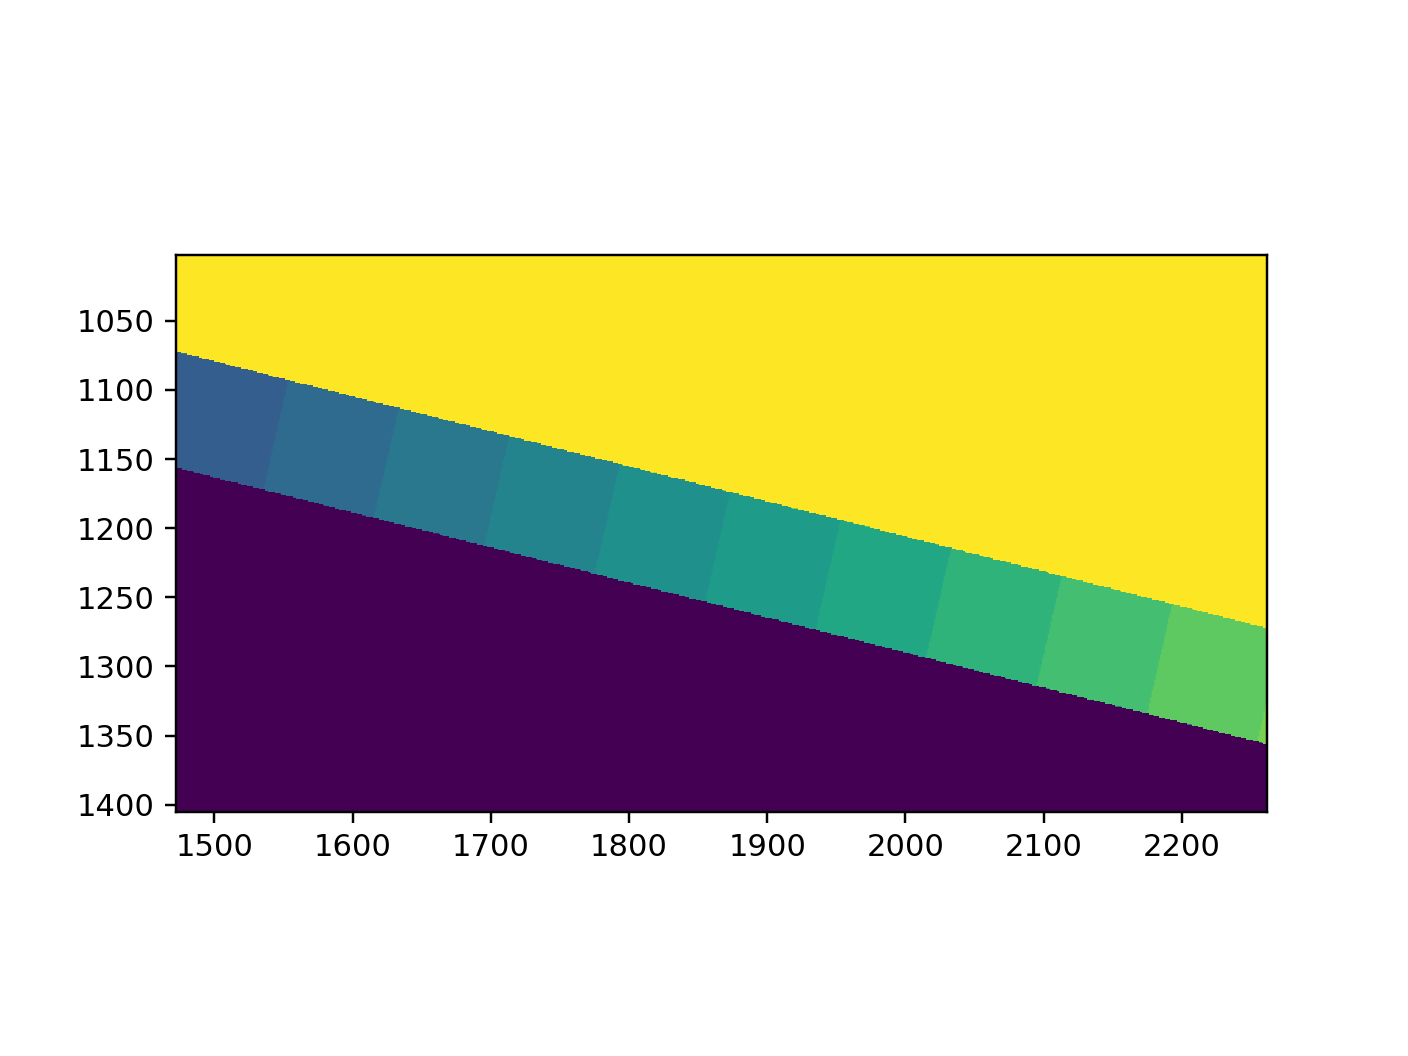

In [27]:
plt.figure()
plt.imshow(ps1_assignment,vmin = ps1_assignment[1000,1000],vmax = ps1_assignment[1000,1000]+20)